In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLM

from tqdm import tqdm
from kmodes.kprototypes import KPrototypes
import plotly.graph_objects as go
from kneed import KneeLocator

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
import math

from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids

from sklearn.preprocessing import PowerTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import shap
from lightgbm import LGBMClassifier

# set the maximum number of rows and columns to display to unlimited
#pd.set_option("display.max_rows", None, "display.max_columns", None) 

# To convert multiple arrays into a single list
def flatten(lis):
    List = []
    for arr in lis:
        if type(arr) == list:
            for a in arr:
                List.append(a)
        else:
            List.append(a)
    return List

C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Create a new dataframe using Study_Day

In [2]:
df = pd.read_csv("C:/Users/Kiat Kai/Desktop/NOTES/FYP/Full Dataset/diamante_eligible_5June.csv")
df.drop(columns = ["Unnamed: 0"], inplace = True)

# FIll the data with missing data with imputating 5 days
df = df.fillna(df.rolling(5,min_periods=1).mean())

In [3]:
# Removed the outlier from today steps
df2 = df[df.today_steps < 50000]

# We want to keep time_msg but it has 828 missing values as the participants did not receive any message at all
# So to keep it, we replace the time_msg NA with T0
df2["time_msg"] = df2["time_msg"].replace(np.nan, "T0")

# VARIABLE: timemsg
df2 = df2.drop(df2[df2.time_msg == "2+ Time Frames"].index, axis = 0)

# We now try to drop columns with missing values at all
df2_dropnan = df2.drop(["eth_other","income_ladder","nat_lang_able","country","years_us","start_phq8_prd",
                          "start_gad_prd","days.since.F0","days.since.F1","days.since.F2","days.since.F3","days.since.F4"
                          ,"days.since.M0","days.since.M1","days.since.M2","days.since.M3","days.since.T1","days.since.T2",
                          "days.since.T3","days.since.T4","days.since.ind","days.since.soc","weekly_goal","yesterday_progress",
                          "week_progress","daybefyest_steps","step_change_yest","step_change_today"], axis=1)

# Next, I also drop columns that I think MAY NOT BE USEFUL for our analysis
df2_dropnan = df2_dropnan.drop(["Fcorrection","Mcorrection","individual","Start_Date",
                                   "date_baseline_visit","prediction","nat_language"] ,axis=1)

# We try to remove all those health questionaire (multiple columns kind)
data_dropnan1 = df2_dropnan.drop(["start_soc_active","start_soc_months","start_ipaq_1","start_ipaq_2","start_ipaq_3",
                                   "start_phq8_1","start_phq8_2","start_phq8_3","start_phq8_4","start_phq8_5","start_phq8_6",
                                   "start_phq8_7","start_phq8_8","start_gad_1","start_gad_2","start_gad_3",
                                   "start_gad_4","start_gad_5","start_gad_6","start_gad_7","start_bads_1r_1",
                                   "start_bads_2_1","start_bads_3_1","start_bads_4_1","start_bads_5_1","start_bads_6r_1",
                                   "start_bads_7r_1","start_bads_8r_1","start_bads_9_1","start_leids_1","start_leids_1",
                                   "start_leids_2","start_leids_3","start_leids_4","start_leids_5","start_leids_6",
                                    "loneliness_1","loneliness_2","loneliness_3","neighborhood_1","neighborhood_2",
                                   "neighborhood_3","neighborhood_4r","neighborhood_5","neighborhood_6","week_steps"]
                                   , axis = 1)

# Next, we remove some rows for some columns which has outliers
# VARIABLE: ETH
data_dropnan1 = data_dropnan1.drop(data_dropnan1[data_dropnan1.eth =="Asian or Pacific Islander,Hispanic/Latino(a)"].index, axis = 0)
data_dropnan1 = data_dropnan1.drop(data_dropnan1[data_dropnan1.eth =="Asian or Pacific Islander,White or Caucasian,Multi-ethnic"].index, axis = 0)
data_dropnan1 = data_dropnan1.drop(data_dropnan1[data_dropnan1.eth =="Asian or Pacific Islander,White or Caucasian"].index, axis = 0)
data_dropnan1 = data_dropnan1.drop(data_dropnan1[data_dropnan1.eth =="White or Caucasian,Hispanic/Latino(a),Multi-ethnic"].index, axis = 0)
data_dropnan1 = data_dropnan1.drop(data_dropnan1[data_dropnan1.eth =="White or Caucasian,Hispanic/Latino(a),Other"].index, axis = 0)
data_dropnan1 = data_dropnan1.drop(data_dropnan1[data_dropnan1.eth =="White or Caucasian,Other"].index, axis = 0)
data_dropnan1 = data_dropnan1.drop(data_dropnan1[data_dropnan1.eth =="Black or African American,Hispanic/Latino(a)"].index, axis = 0)

# VARIABLE: gender
data_dropnan1 = data_dropnan1.drop(data_dropnan1[data_dropnan1.gender == "Other or Not Listed; Please Specify:"].index, axis = 0)

# Remove rows with anymore nan's
data_dropnan1 = data_dropnan1.dropna()

# FINAL DATASET: (With day of the week)
filled_dataset = data_dropnan1


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
#######################################################################################################
## To create frequency of feedback and motivational and time_msg for the weeks for each participants ##
#######################################################################################################

df_participants = filled_dataset.ID_DIAMANTE.unique() # 76 participants with different id
df_participants_weekly_feedback_counts = []
df_participants_weekly_motivational_counts = []
df_participants_weekly_time_msg_counts = []

for participant in df_participants:
    weekly_feedback_count = []
    weekly_motivational_count = []
    weekly_time_msg_count = []
    df_participant = filled_dataset[filled_dataset.ID_DIAMANTE == participant].reset_index().drop(["index"],axis=1)
    
    # For week 1:
    df_participant_feedback_week_1 = dict(df_participant.feedback.loc[0:6].value_counts())
    weekly_feedback_count.append(df_participant_feedback_week_1)
    df_participant_motivational_week_1 = dict(df_participant.motivational.loc[0:6].value_counts())
    weekly_motivational_count.append(df_participant_motivational_week_1)
    df_participant_time_msg_week_1 = dict(df_participant.time_msg.loc[0:6].value_counts())
    weekly_time_msg_count.append(df_participant_time_msg_week_1)
    
    # For week 2:
    df_participant_feedback_week_2 = dict(df_participant.feedback.loc[7:13].value_counts())
    weekly_feedback_count.append(df_participant_feedback_week_2)
    df_participant_motivational_week_2 = dict(df_participant.motivational.loc[7:13].value_counts())
    weekly_motivational_count.append(df_participant_motivational_week_2)
    df_participant_time_msg_week_2 = dict(df_participant.time_msg.loc[7:13].value_counts())
    weekly_time_msg_count.append(df_participant_time_msg_week_2)
    
    # For week 3:
    df_participant_feedback_week_3 = dict(df_participant.feedback.loc[14:20].value_counts())
    weekly_feedback_count.append(df_participant_feedback_week_3)
    df_participant_motivational_week_3 = dict(df_participant.motivational.loc[14:20].value_counts())
    weekly_motivational_count.append(df_participant_motivational_week_3)
    df_participant_time_msg_week_3 = dict(df_participant.time_msg.loc[14:20].value_counts())
    weekly_time_msg_count.append(df_participant_time_msg_week_3)
    
    # For week 4:
    df_participant_feedback_week_4 = dict(df_participant.feedback.loc[21:27].value_counts())
    weekly_feedback_count.append(df_participant_feedback_week_4)
    df_participant_motivational_week_4 = dict(df_participant.motivational.loc[21:27].value_counts())
    weekly_motivational_count.append(df_participant_motivational_week_4)
    df_participant_time_msg_week_4 = dict(df_participant.time_msg.loc[21:27].value_counts())
    weekly_time_msg_count.append(df_participant_time_msg_week_4)
    
    # For week 5:
    df_participant_feedback_week_5 = dict(df_participant.feedback.loc[28:34].value_counts())
    weekly_feedback_count.append(df_participant_feedback_week_5)
    df_participant_motivational_week_5 = dict(df_participant.motivational.loc[28:34].value_counts())
    weekly_motivational_count.append(df_participant_motivational_week_5)
    df_participant_time_msg_week_5 = dict(df_participant.time_msg.loc[28:34].value_counts())
    weekly_time_msg_count.append(df_participant_time_msg_week_5)
    
    # For week 6:
    df_participant_feedback_week_6 = dict(df_participant.feedback.loc[35:41].value_counts())
    weekly_feedback_count.append(df_participant_feedback_week_6)
    df_participant_motivational_week_6 = dict(df_participant.motivational.loc[35:41].value_counts())
    weekly_motivational_count.append(df_participant_motivational_week_6)
    df_participant_time_msg_week_6 = dict(df_participant.time_msg.loc[35:41].value_counts())
    weekly_time_msg_count.append(df_participant_time_msg_week_6)
    
    # For week 7:
    df_participant_feedback_week_7 = dict(df_participant.feedback.loc[42:44].value_counts())
    weekly_feedback_count.append(df_participant_feedback_week_7)
    df_participant_motivational_week_7 = dict(df_participant.motivational.loc[42:44].value_counts())
    weekly_motivational_count.append(df_participant_motivational_week_7)
    df_participant_time_msg_week_7 = dict(df_participant.time_msg.loc[42:44].value_counts())
    weekly_time_msg_count.append(df_participant_time_msg_week_7)
    
    df_participants_weekly_feedback_counts.append(weekly_feedback_count)
    df_participants_weekly_motivational_counts.append(weekly_motivational_count)
    df_participants_weekly_time_msg_counts.append(weekly_time_msg_count)

In [5]:
df_participants = filled_dataset.ID_DIAMANTE.unique() # 76 participants with different id
weekly_goals = []  # To store all the weekly goals for each participants every 7th day
weekly_steps = []  # To store all the weekly steps for each participants every 7th day
weekly_day_counts = [] # To store all the number of days per week for each participants
weekly_average = [] # To store all the weekly average steps for each participants
weekly_goals_average = [] 

##########################################################################################
########### To store all the daily_goals for each week for each participants #############
##########################################################################################
count = 0
for participant in df_participants:
    individual_weekly_goals = np.zeros(7)              # To record the weekly goals for each participants
    individual_weekly_steps = np.zeros(7)              # To record the weekly steps for each participants
    weekly_days = np.zeros(7)                     # To record the number of days for each week 
    weekly_average_steps = np.zeros(7)            # To record the average weekly steps for each week
    weekly_average_goals = np.zeros(7)            # To record the average weekly goals for each week
    
    # study days the participants have after removing NA's
    study_days = list(filled_dataset[filled_dataset["ID_DIAMANTE"] == participant].Study_Day) 

    for day in study_days:
        index = study_days.index(day)
        df_participant_dailygoal = filled_dataset[filled_dataset["ID_DIAMANTE"] == participant].daily_goal.reset_index().drop(["index"],axis=1)
        df_participant_todaystep = filled_dataset[filled_dataset["ID_DIAMANTE"] == participant].today_steps.reset_index().drop(["index"],axis=1)
        
        if day >= 1 and day <= 7:         # Week 1 
            individual_weekly_goals[0] += df_participant_dailygoal.loc[index]
            individual_weekly_steps[0] += df_participant_todaystep.loc[index]
            weekly_days[0] += 1 
            weekly_average_steps[0] = individual_weekly_steps[0]/weekly_days[0]
            weekly_average_goals[0] = individual_weekly_goals[0]/weekly_days[0]
            
        elif day > 7 and day <= 14:       # Week 2
            individual_weekly_goals[1] += df_participant_dailygoal.loc[index]
            individual_weekly_steps[1] += df_participant_todaystep.loc[index]
            weekly_days[1] += 1 
            weekly_average_steps[1] = individual_weekly_steps[1]/weekly_days[1]
            weekly_average_goals[1] = individual_weekly_goals[1]/weekly_days[1]

        elif day > 14 and day <= 21:      # Week 3
            individual_weekly_goals[2] += df_participant_dailygoal.loc[index]
            individual_weekly_steps[2] += df_participant_todaystep.loc[index]
            weekly_days[2] += 1
            weekly_average_steps[2] = individual_weekly_steps[2]/weekly_days[2]
            weekly_average_goals[2] = individual_weekly_goals[2]/weekly_days[2]

        elif day > 21 and day <= 28:      # Week 4
            individual_weekly_goals[3] += df_participant_dailygoal.loc[index]
            individual_weekly_steps[3] += df_participant_todaystep.loc[index]
            weekly_days[3] += 1
            weekly_average_steps[3] = individual_weekly_steps[3]/weekly_days[3]
            weekly_average_goals[3] = individual_weekly_goals[3]/weekly_days[3]
    
        elif day > 28 and day <= 35:      # Week 5
            individual_weekly_goals[4] += df_participant_dailygoal.loc[index]
            individual_weekly_steps[4] += df_participant_todaystep.loc[index]
            weekly_days[4] += 1
            weekly_average_steps[4] = individual_weekly_steps[4]/weekly_days[4]
            weekly_average_goals[4] = individual_weekly_goals[4]/weekly_days[4]
          
        elif day > 35 and day <= 42:      # Week 6
            individual_weekly_goals[5] += df_participant_dailygoal.loc[index]
            individual_weekly_steps[5] += df_participant_todaystep.loc[index]
            weekly_days[5] += 1 
            weekly_average_steps[5] = individual_weekly_steps[5]/weekly_days[5]
            weekly_average_goals[5] = individual_weekly_goals[5]/weekly_days[5]

        elif day > 42 and day <= 45:      # Week 7
            individual_weekly_goals[6] += df_participant_dailygoal.loc[index]
            individual_weekly_steps[6] += df_participant_todaystep.loc[index]
            weekly_days[6] += 1 
            weekly_average_steps[6] = individual_weekly_steps[6]/weekly_days[6]
            weekly_average_goals[6] = individual_weekly_goals[6]/weekly_days[6]

    weekly_goals.append(individual_weekly_goals)   
    weekly_steps.append(individual_weekly_steps)   
    weekly_day_counts.append(weekly_days)
    weekly_average.append(weekly_average_steps)
    weekly_goals_average.append(weekly_average_goals)

#print(weekly_goals)
#print(weekly_day_counts)
#print(weekly_steps)
#print(weekly_average)

In [6]:
# To create a single list for feedback
feedback_new = flatten(df_participants_weekly_feedback_counts)
feedback_df = pd.DataFrame(feedback_new).fillna(0).astype(int)
#print(feedback_df)

# To create a single list for motivational
motivational_new = flatten(df_participants_weekly_motivational_counts)
motivational_df = pd.DataFrame(motivational_new).fillna(0).astype(int)
#print(motivational_df)

# To create a single list for time_msg
time_msg_new = flatten(df_participants_weekly_time_msg_counts)
time_msg_df = pd.DataFrame(time_msg_new).fillna(0).astype(int)
#print(time_msg_df)

#########################################################
#### Merge the above dataframes into 1 big dataframe ####
#########################################################
feedback_motivational = feedback_df.join(motivational_df)

In [7]:
#########################################################################################################
## This portion here we are trying to create a new dataframe (aggregated one) for weekly_average_steps ##
#########################################################################################################

df_participants = filled_dataset.ID_DIAMANTE.unique() # 76 participants with different id

# To create a single list for weekly_average_steps
weekly_average_new = []
for i in range(len(weekly_average)):
    for j in range(len(weekly_average[i])):
        weekly_average_new.append(weekly_average[i][j])
        
# To create a single list for weekly_goal
weekly_goals_new = []
for i in range(len(weekly_goals)):
    for j in range(len(weekly_goals[i])):
        weekly_goals_new.append(weekly_goals[i][j])

# To create a single list for ID_DIAMANTE 
ID_DIAMANTE_new = []
for i in range(len(df_participants)):
    num_week_participant = len(weekly_day_counts[i])
    ID_DIAMANTE_new.append([df_participants[i]] * num_week_participant)
ID_DIAMANTE_new = flatten(ID_DIAMANTE_new)

# Create New DataFrame
data = {"ID_DIAMANTE":ID_DIAMANTE_new,"weekly_goal":weekly_goals_new, "weekly_average":weekly_average_new}
df_weekly = pd.DataFrame(data)

##############################################################
#### Merge the this dataframe with feedback/motivational  ####
##############################################################
df_new_weekly = df_weekly.join(feedback_motivational)
df_new_weekly.insert(1, 'week_number', list(range(1,8)) * len(df_participants)) # To create a new column called week number

In [8]:
#######################################
######### Numerical variables #########
#######################################
arm_new = pd.DataFrame(filled_dataset.groupby(["ID_DIAMANTE"]).mean().arm)
age_new = pd.DataFrame(filled_dataset.groupby(["ID_DIAMANTE"]).mean().age)
adults_household_new = pd.DataFrame(filled_dataset.groupby(["ID_DIAMANTE"]).mean().adults_household)
child_household_new = pd.DataFrame(filled_dataset.groupby(["ID_DIAMANTE"]).mean().child_household)
phq_sumnew_new = pd.DataFrame(filled_dataset.groupby(["ID_DIAMANTE"]).mean().phq_sumnew)
GAD_sum_new = pd.DataFrame(filled_dataset.groupby(["ID_DIAMANTE"]).mean().GAD_sum)
leids_sum_new = pd.DataFrame(filled_dataset.groupby(["ID_DIAMANTE"]).mean().leids_sum)
BADS_sum_new = pd.DataFrame(filled_dataset.groupby(["ID_DIAMANTE"]).mean().BADS_sum)
neighborhood_sum_new = pd.DataFrame(filled_dataset.groupby(["ID_DIAMANTE"]).mean().neighborhood_sum)
loneliness_sum_new = pd.DataFrame(filled_dataset.groupby(["ID_DIAMANTE"]).mean().loneliness_sum)
PA_sum_new = pd.DataFrame(filled_dataset.groupby(["ID_DIAMANTE"]).mean().PA_sum)

variables_new = [arm_new, age_new, adults_household_new, child_household_new, phq_sumnew_new, 
         GAD_sum_new, leids_sum_new, BADS_sum_new, neighborhood_sum_new, loneliness_sum_new, PA_sum_new]
for var in variables_new:
    df_new_weekly = pd.merge(df_new_weekly, var, on=["ID_DIAMANTE"])

In [9]:
#########################################
######### Categorical variables #########
#########################################
gender_new = pd.DataFrame(filled_dataset.groupby(["ID_DIAMANTE"]).gender.describe().top)
gender_new = gender_new.rename(columns={"top":"gender"})

eth_new = pd.DataFrame(filled_dataset.groupby(["ID_DIAMANTE"]).eth.describe().top)
eth_new = eth_new.rename(columns={"top":"eth"})

edu_new = pd.DataFrame(filled_dataset.groupby(["ID_DIAMANTE"]).edu.describe().top)
edu_new = edu_new.rename(columns={"top":"edu"})

employed_new = pd.DataFrame(filled_dataset.groupby(["ID_DIAMANTE"]).employed.describe().top)
employed_new = employed_new.rename(columns={"top":"employed"})

basics_challenges_r_new = pd.DataFrame(filled_dataset.groupby(["ID_DIAMANTE"]).basics_challenges_r.describe().top)
basics_challenges_r_new = basics_challenges_r_new.rename(columns={"top":"basics_challenges_r"})

marital_status_new = pd.DataFrame(filled_dataset.groupby(["ID_DIAMANTE"]).marital_status.describe().top)
marital_status_new = marital_status_new.rename(columns={"top":"marital_status"})

health_lit_new = pd.DataFrame(filled_dataset.groupby(["ID_DIAMANTE"]).health_lit.describe().top)
health_lit_new = health_lit_new.rename(columns={"top":"health_lit"})

health_status_new = pd.DataFrame(filled_dataset.groupby(["ID_DIAMANTE"]).health_status.describe().top)
health_status_new = health_status_new.rename(columns={"top":"health_status"})

pain_new = pd.DataFrame(filled_dataset.groupby(["ID_DIAMANTE"]).pain.describe().top)
pain_new = pain_new.rename(columns={"top":"pain"})

social_phone_new = pd.DataFrame(filled_dataset.groupby(["ID_DIAMANTE"]).social_phone.describe().top)
social_phone_new = social_phone_new.rename(columns={"top":"social_phone"})

social_meet_new = pd.DataFrame(filled_dataset.groupby(["ID_DIAMANTE"]).social_meet.describe().top)
social_meet_new = social_meet_new.rename(columns={"top":"social_meet"})

social_rel_new = pd.DataFrame(filled_dataset.groupby(["ID_DIAMANTE"]).social_rel.describe().top)
social_rel_new = social_rel_new.rename(columns={"top":"social_rel"})

sms_contact_new = pd.DataFrame(filled_dataset.groupby(["ID_DIAMANTE"]).sms_contact.describe().top)
sms_contact_new = sms_contact_new.rename(columns={"top":"sms_contact"})

text_freq_new = pd.DataFrame(filled_dataset.groupby(["ID_DIAMANTE"]).text_freq.describe().top)
text_freq_new = text_freq_new.rename(columns={"top":"text_freq"})

smartphonetype_new = pd.DataFrame(filled_dataset.groupby(["ID_DIAMANTE"]).smartphonetype.describe().top)
smartphonetype_new = smartphonetype_new.rename(columns={"top":"smartphonetype"})

phq_cat_new = pd.DataFrame(filled_dataset.groupby(["ID_DIAMANTE"]).phq_cat.describe().top)
phq_cat_new = phq_cat_new.rename(columns={"top":"phq_cat"})

GAD_cat_new = pd.DataFrame(filled_dataset.groupby(["ID_DIAMANTE"]).GAD_cat.describe().top)
GAD_cat_new = GAD_cat_new.rename(columns={"top":"GAD_cat"})

leids_cat_new = pd.DataFrame(filled_dataset.groupby(["ID_DIAMANTE"]).leids_cat.describe().top)
leids_cat_new = leids_cat_new.rename(columns={"top":"leids_cat"})

lonely_cat_new = pd.DataFrame(filled_dataset.groupby(["ID_DIAMANTE"]).lonely_cat.describe().top)
lonely_cat_new = lonely_cat_new.rename(columns={"top":"lonely_cat"})

variables_cat = [gender_new, eth_new, edu_new, employed_new, basics_challenges_r_new, marital_status_new, health_lit_new,
                health_status_new, pain_new, social_phone_new, social_meet_new, social_rel_new, sms_contact_new,
                 text_freq_new, smartphonetype_new, phq_cat_new, GAD_cat_new, leids_cat_new, lonely_cat_new]
for var in variables_cat:
    df_new_weekly = pd.merge(df_new_weekly, var, on=["ID_DIAMANTE", "ID_DIAMANTE"])

#################################################################################################
##### FOR WEEKLY_AVERAGE_STEPS, WE WILL NOW USE THE NEW DATAFRAME: df_new_weekly_bystudydays #####
#################################################################################################
#### We need to remove those rows with 0 weekly_steps ####
df_new_weekly_bystudydays = df_new_weekly[df_new_weekly["weekly_average"] != 0]

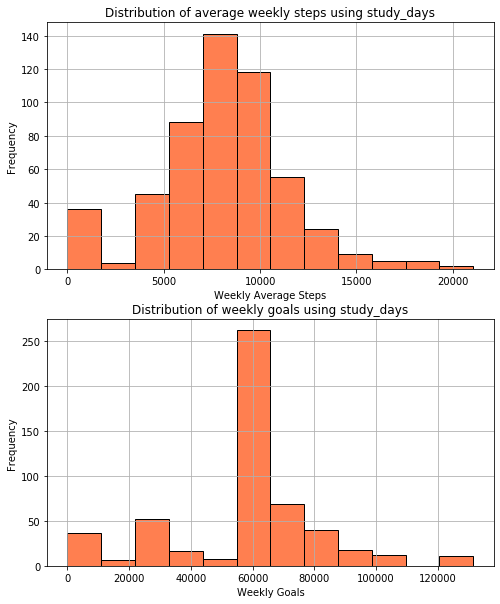

In [10]:
################################################################################################################
################## Exploratory Descriptive Analysis for weekly_average_steps using study_days ##################
################################################################################################################

plt.figure(figsize=(8,10))

plt.subplot(2,1,1)
overall_weekly_dist = np.array(weekly_average).flatten() # To make into 1 list instead of multiple list in a big list
plt.hist(overall_weekly_dist, ec = "black", bins = 12, color = "coral")
plt.ylabel("Frequency")
plt.xlabel("Weekly Average Steps")
plt.title("Distribution of average weekly steps using study_days")
plt.grid(b="dark")
plt.savefig("weekly_average.tif")

plt.subplot(2,1,2)
overall_weekly_dist = np.array(weekly_goals).flatten() # To make into 1 list instead of multiple list in a big list
plt.hist(overall_weekly_dist, ec = "black", bins = 12, color = "coral")
plt.ylabel("Frequency")
plt.xlabel("Weekly Goals")
plt.title("Distribution of weekly goals using study_days")
plt.grid(b="dark")
plt.savefig("weekly_goal.tif")

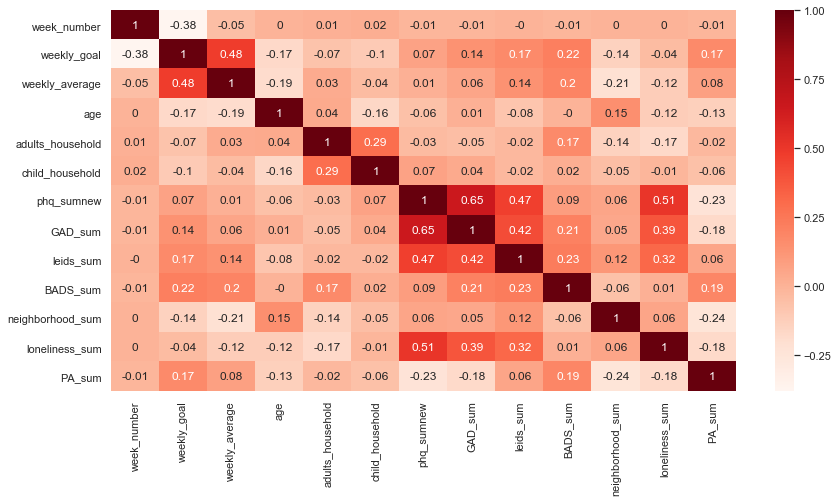

In [11]:
# change arm from int to object
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"arm":"object"})
#df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"week_number":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"M0":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"M1":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"M2":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"M3":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"F0":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"F1":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"F2":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"F3":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"F4":"object"})

# Correlation between numerical variables in the data set
correlation_matrix = df_new_weekly_bystudydays.corr().round(2)

sns.set(rc={'figure.figsize':(14,7)})
ax = sns.heatmap(data=correlation_matrix, annot=True, cmap = "Reds")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.savefig("correlation2.tif")

## Random Forest

Mean Absolute Error: 1751.53 with training data from week 1 to week 1 and test data from week 2 onwards.
Mean Squared Error: 5228543.51 with training data from week 1 to week 1 and test data from week 2 onwards.
R^2 score: 0.373 with training data from week 1 to week 1 and test data from week 2 onwards.
Mean Absolute Error: 1676.21 with training data from week 1 to week 2 and test data from week 3 onwards.
Mean Squared Error: 4906072.84 with training data from week 1 to week 2 and test data from week 3 onwards.
R^2 score: 0.4452 with training data from week 1 to week 2 and test data from week 3 onwards.
Mean Absolute Error: 1608.29 with training data from week 1 to week 3 and test data from week 4 onwards.
Mean Squared Error: 4772795.6 with training data from week 1 to week 3 and test data from week 4 onwards.
R^2 score: 0.4618 with training data from week 1 to week 3 and test data from week 4 onwards.
Mean Absolute Error: 1756.53 with training data from week 1 to week 4 and test data 

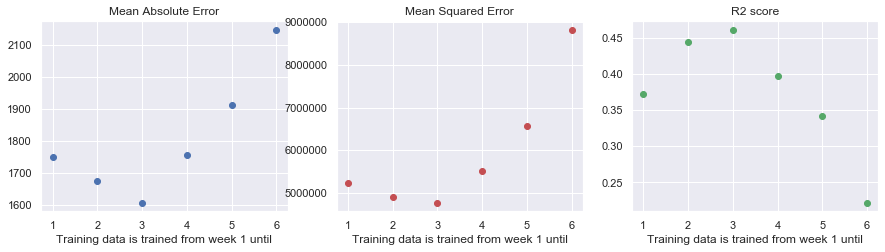

In [12]:
# Labels are the values we want to predict
labels = df_new_weekly_bystudydays['weekly_average']

# Convert categorical data into dummy variables
features = df_new_weekly_bystudydays.drop(['weekly_average',"ID_DIAMANTE"], axis = 1)
features = pd.get_dummies(features)

# Create a vector to store mean absolute error (MAE)
MAE = np.zeros(7)
# Create a vector to store mean squared error (MSE)
MSE = np.zeros(7)
# Create a vector to store R^2 score (R2 score)
R2score = np.zeros(7)

# Number of trees needed for random forest is typically set as p/3 (regression) # From DSA4211
m = math.floor(features.shape[1]/3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,3.5))

# Split into Xtrain, Xtest, Ytrain, Ytest
for i in range(1,7):
    index = 1
    train_index, test_index = features[features["week_number"] <= i].index, features[features["week_number"] > i].index
    train_index, test_index = list(train_index), list(test_index)
    Xtrain, ytrain = np.array(features.loc[train_index]), np.array(labels.loc[train_index])
    Xtest, ytest = np.array(features.loc[test_index]), np.array(labels.loc[test_index])

    # Instantiate model with m decision trees
    rf = RandomForestRegressor(n_estimators = 1000, max_features = m, random_state = 10)
    # Train the model on training data
    rf.fit(Xtrain, ytrain)
    
    # Use the forest's predict method on the test data
    predictions = rf.predict(Xtest)

    # Calculate the absolute errors
    errors = abs(predictions - ytest)
    # Print out the mean absolute error (MAE)
    print('Mean Absolute Error:', round(np.mean(errors), 2), "with training data from week 1 to week", i
          , "and test data from week", i+1, "onwards.")
    MAE[index] = round(np.mean(errors), 2)
    ax1.plot(i, MAE[index], "bo")
    ax1.set_title("Mean Absolute Error")
    ax1.set(xlabel="Training data is trained from week 1 until")
    
    # Print out the mean squared error (MSE)
    mse = np.mean((ytest-predictions)**2)
    print('Mean Squared Error:', round(mse, 2), "with training data from week 1 to week", i
         , "and test data from week", i+1, "onwards.")
    MSE[index] = mse
    ax2.plot(i, MSE[index], "ro")
    ax2.set_title("Mean Squared Error")
    ax2.set(xlabel="Training data is trained from week 1 until")
    
    # Print R^2 score
    r2score = r2_score(ytest, predictions)
    print("R^2 score:", round(r2score, 4), "with training data from week 1 to week", i
         , "and test data from week", i+1, "onwards.")
    R2score[index] = r2score
    ax3.plot(i, R2score[index], "go")
    ax3.set_title("R2 score")
    ax3.set(xlabel="Training data is trained from week 1 until")
    
    index += 1

plt.show()

In [13]:
## We use training data from week 1 to week 3 and test data from week 4 onwards
train_index, test_index = features[features["week_number"] <= 3].index, features[features["week_number"] > 3].index
train_index, test_index = list(train_index), list(test_index)
Xtrain, ytrain = np.array(features.loc[train_index]), np.array(labels.loc[train_index])
Xtest, ytest = np.array(features.loc[test_index]), np.array(labels.loc[test_index])

# Number of trees needed for random forest is typically set as p/3 (regression) 
m = math.floor(features.shape[1]/3)

# Instantiate model with m decision trees
rf = RandomForestRegressor(n_estimators = 1000, max_features = m, random_state = 10)
# Train the model on training data
rf.fit(Xtrain, ytrain)

# Get numerical feature importances
importances = list(rf.feature_importances_)

# Feature_list
feature_list = list(features.columns)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: weekly_goal          Importance: 0.241
Variable: neighborhood_sum     Importance: 0.056
Variable: BADS_sum             Importance: 0.044
Variable: PA_sum               Importance: 0.034
Variable: GAD_sum              Importance: 0.03
Variable: age                  Importance: 0.025
Variable: leids_sum            Importance: 0.024
Variable: phq_sumnew           Importance: 0.023
Variable: adults_household     Importance: 0.02
Variable: edu_High school graduate or "GED" degree Importance: 0.018
Variable: social_rel_About once per week Importance: 0.018
Variable: week_number          Importance: 0.017
Variable: health_lit_Not at all Importance: 0.014
Variable: loneliness_sum       Importance: 0.013
Variable: health_status_Very Good Importance: 0.011
Variable: employed_Other       Importance: 0.01
Variable: health_lit_Extremely Importance: 0.008
Variable: social_phone_Less than everyday, but several times per week Importance: 0.008
Variable: child_household      Importance: 0.007

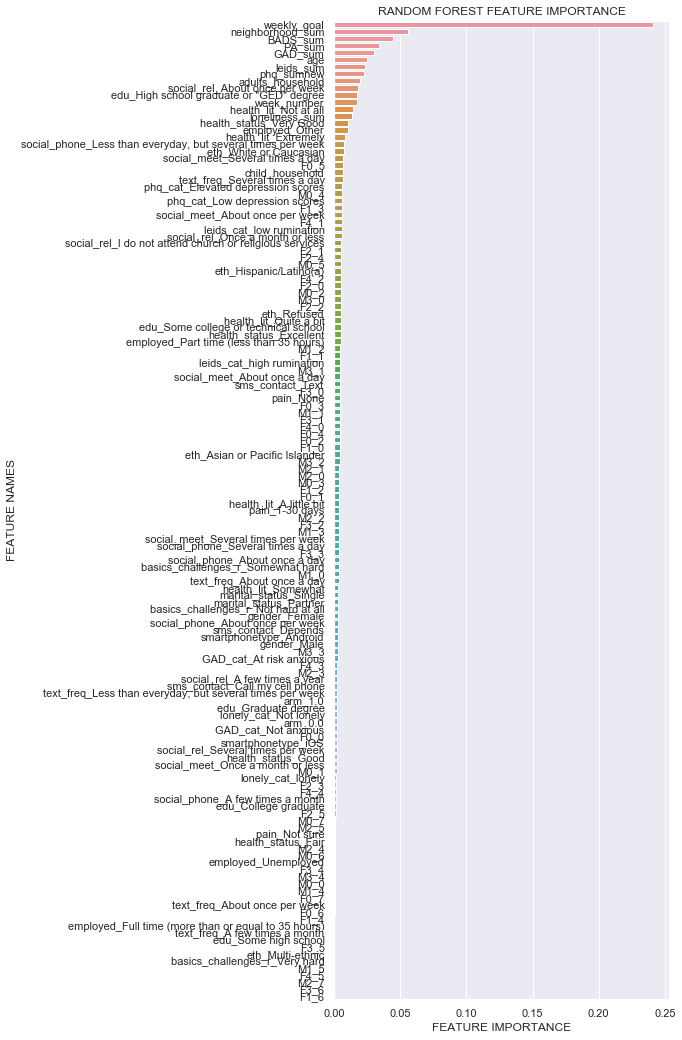

In [14]:
# Plotting out the importance of the variables
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(6,18))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.savefig('RF importance.jpg', bbox_inches = 'tight')

plot_feature_importance(importances, features.loc[train_index].columns, "RANDOM FOREST")

In [15]:
# Run kprototypes with importance at least 0.006 and above (remove edu and eth and employed)
from sklearn.preprocessing import StandardScaler

# change arm from int to object
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"arm":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"week_number":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"M0":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"M1":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"M2":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"M3":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"F0":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"F1":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"F2":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"F3":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"F4":"object"})

# Separating out the features
features = df_new_weekly_bystudydays[["weekly_goal","weekly_average","neighborhood_sum","BADS_sum","social_rel","health_lit","text_freq",
                                    "age","GAD_sum","leids_sum","week_number","adults_household","phq_sumnew","PA_sum",
                                     "health_status","loneliness_sum","social_meet","social_phone","F0","F1","F2"
                                      ,"F3","F4","M0","M1","M2","M3","arm","child_household"]]

# Categorical features (drop out those continuous variables)
cat_features = features.drop(["week_number","weekly_goal",
                             "weekly_average","neighborhood_sum","BADS_sum","age","GAD_sum","leids_sum",
                             "adults_household","child_household","phq_sumnew","PA_sum","loneliness_sum"], axis=1).reset_index()

# Continuous features
cont_features = features[["weekly_goal","weekly_average","neighborhood_sum","BADS_sum","age","GAD_sum","leids_sum",
                             "adults_household","child_household","phq_sumnew","PA_sum","loneliness_sum"]]

# Standardizing the continuous features
features_stand = StandardScaler().fit_transform(cont_features)
features_stand = pd.DataFrame(features_stand, columns = ["weekly_goal","weekly_average","neighborhood_sum","BADS_sum","age","GAD_sum"
                                                         ,"leids_sum","adults_household","child_household","phq_sumnew","PA_sum",
                                                         "loneliness_sum"]).reset_index()

# Features that don't need to be changed
features_same = features["week_number"]

# Combining back the categorical and numerical variables
df_weekly_stand_new = pd.concat([cat_features, features_same, features_stand], axis=1, sort=False)
# Drop the index column
#pd.set_option("display.max_rows", 5, "display.max_columns", None) 
df_weekly_stand_new = df_weekly_stand_new.drop(["index"],axis=1) # remove the index column
df_weekly_stand_new = df_weekly_stand_new.dropna() # drop the nan

df_for_r_weekly_studydays = pd.concat([cat_features, features_same, cont_features], axis=1, sort=False)
df_for_r_weekly_studydays.to_csv("weekly_studydays_R.csv")


## K-prototypes

### Weekly_average_steps for arm 0 

In [16]:
# Split into training and test set

df_arm_0 = df_weekly_stand_new[df_weekly_stand_new["arm"] == 0]
train_set = df_arm_0[df_arm_0["week_number"] <= 3]
test_set = df_arm_0[df_arm_0["week_number"] > 3]

# Setting the objects to category
cat_data = test_set.copy()
for j in cat_data.select_dtypes("object"):
    cat_data[j] = cat_data[j].astype("category")

# Elbow plot with cost (will take a LONG time)
costs = []
n_clusters = []
clusters_assigned = []
F1_scores = pd.DataFrame(columns = ['Number of clusters', 'F1 score'])

for i in tqdm(range(2, 18)):
    try:        
        # Step 1: Initialize the function by specifying the number of clusters
        kproto = KPrototypes(n_clusters= i, init='Huang', verbose=2, random_state = 100)
    
        # Step 2: To build the clusters, fit.predict the data using training set
        clusters = kproto.fit_predict(train_set, categorical=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
        
        # Step 3: Append the cost and number of clusters used to compute the cost to appropriate lists
        costs.append(kproto.cost_)
        n_clusters.append(i)
        clusters_assigned.append(clusters)
        
        # Predicted Clusters using test set
        kproto_test = KPrototypes(n_clusters= i, init='Huang', verbose=2, random_state = 100)
        clusters_test = kproto_test.fit_predict(test_set, categorical=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

        # kprototypes labels
        proto_labs = kproto_test.labels_  

        clf_kp = LGBMClassifier(colsample_by_tree = 0.8)
        cv_scores_kp_test = cross_val_score(clf_kp, cat_data, proto_labs, scoring = "f1_weighted")
        print(f'CV F1 score for {i}-prototypes clusters is {np.mean(cv_scores_kp_test)}')
        
        # Create a dataframe to store the F1_scores for all the different clusters
        F1_scores = F1_scores.append(pd.DataFrame({'Number of clusters': i, 
                                                       'F1 score': np.mean(cv_scores_kp_test)},
                                                       index = [0]),
                                         ignore_index = True)
        
        
    except:
        print(f"Can't cluster with {i} clusters")
        


# Construct an elbow plot to find the optimal number for K
fig = go.Figure(data=go.Scatter(x=n_clusters, y=costs ))
fig.show()

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 21, ncost: 2406.369179769744
Run: 1, iteration: 2/100, moves: 9, ncost: 2396.6156447607677
Run: 1, iteration: 3/100, moves: 3, ncost: 2394.3209598830335
Run: 1, iteration: 4/100, moves: 3, ncost: 2392.5098753636958
Run: 1, iteration: 5/100, moves: 0, ncost: 2392.5098753636958
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 22, ncost: 2421.7707096541158
Run: 2, iteration: 2/100, moves: 13, ncost: 2402.25614839877
Run: 2, iteration: 3/100, moves: 3, ncost: 2401.0520893322814
Run: 2, iteration: 4/100, moves: 0, ncost: 2401.0520893322814
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 17, ncost: 2398.183182812176
Run: 3, iteration: 2/100, moves: 6, ncost: 2392.529429870571
Run: 3, iteration: 3/100, moves: 6, ncost: 2386.6953178815434
Run: 3, iteration

Run: 10, iteration: 4/100, moves: 3, ncost: 2944.990842801264
Run: 10, iteration: 5/100, moves: 1, ncost: 2944.807551942273
Run: 10, iteration: 6/100, moves: 0, ncost: 2944.807551942273
Best run was number 2
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 2-prototypes clusters is 0.790271658329359


  6%|█████▏                                                                             | 1/16 [00:05<01:18,  5.25s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 36, ncost: 2166.8946752166794
Run: 1, iteration: 2/100, moves: 12, ncost: 2151.320526062916
Run: 1, iteration: 3/100, moves: 8, ncost: 2145.7764096212986
Run: 1, iteration: 4/100, moves: 2, ncost: 2145.5389238104826
Run: 1, iteration: 5/100, moves: 1, ncost: 2145.408973556754
Run: 1, iteration: 6/100, moves: 0, ncost: 2145.408973556754
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 29, ncost: 2291.230467785041
Run: 2, iteration: 2/100, moves: 25, ncost: 2210.6140942135703
Run: 2, iteration: 3/100, moves: 6, ncost: 2206.2866163024473
Run: 2, iteration: 4/100, moves: 7, ncost: 2199.0096990086618
Run: 2, iteration: 5/100, moves: 3, ncost: 2197.1242773789827
Run: 2, iteration: 6/100, moves: 0, ncost: 2197.1242773789827
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteratio

Run: 7, iteration: 5/100, moves: 1, ncost: 2783.687393342415
Run: 7, iteration: 6/100, moves: 0, ncost: 2783.687393342415
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 8, iteration: 1/100, moves: 26, ncost: 2896.103590272853
Run: 8, iteration: 2/100, moves: 28, ncost: 2811.729751577824
Run: 8, iteration: 3/100, moves: 27, ncost: 2736.207238544271
Run: 8, iteration: 4/100, moves: 13, ncost: 2723.0992582452473
Run: 8, iteration: 5/100, moves: 1, ncost: 2722.9512090912913
Run: 8, iteration: 6/100, moves: 0, ncost: 2722.9512090912913
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 9, iteration: 1/100, moves: 35, ncost: 2797.441660040895
Run: 9, iteration: 2/100, moves: 20, ncost: 2758.4494395672486
Run: 9, iteration: 3/100, moves: 12, ncost: 2733.9685370555176
Run: 9, iteration: 4/100, moves: 15, ncost: 2712.749929832281
Run: 9, iteration: 5/100, moves: 3, ncost: 2710.230168628548
Run: 9, iteration: 6/100, moves: 0

The least populated class in y has only 4 members, which is less than n_splits=5.


[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 3-prototypes clusters is 0.8797069896927834


 12%|██████████▍                                                                        | 2/16 [00:11<01:18,  5.60s/it]

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 35, ncost: 2153.879459752796
Run: 1, iteration: 2/100, moves: 6, ncost: 2144.638559293823
Run: 1, iteration: 3/100, moves: 6, ncost: 2139.918828614625
Run: 1, iteration: 4/100, moves: 0, ncost: 2139.918828614625
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 32, ncost: 2163.2183197871905
Run: 2, iteration: 2/100, moves: 21, ncost: 2102.6236935213988
Run: 2, iteration: 3/100, moves: 1, ncost: 2101.5193992182444
Run: 2, iteration: 4/100, moves: 0, ncost: 2101.5193992182444
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 20, ncost: 2146.793793388314
Run: 3, iteration: 2/100, moves: 11, ncost: 2128.0219855031937
Run: 3, iteration: 3/100, 

Init: initializing clusters
Starting iterations...
Run: 10, iteration: 1/100, moves: 64, ncost: 2610.12793492654
Run: 10, iteration: 2/100, moves: 14, ncost: 2592.455573294716
Run: 10, iteration: 3/100, moves: 8, ncost: 2585.663327931001
Run: 10, iteration: 4/100, moves: 2, ncost: 2582.8093583577283
Run: 10, iteration: 5/100, moves: 6, ncost: 2574.219398394494
Run: 10, iteration: 6/100, moves: 6, ncost: 2565.148681242249
Run: 10, iteration: 7/100, moves: 0, ncost: 2565.148681242249
Best run was number 4


The least populated class in y has only 4 members, which is less than n_splits=5.


[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 4-prototypes clusters is 0.7738070257340034


 19%|███████████████▌                                                                   | 3/16 [00:17<01:15,  5.79s/it]

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 29, ncost: 2054.461954872758
Run: 1, iteration: 2/100, moves: 13, ncost: 2027.8810684118823
Run: 1, iteration: 3/100, moves: 5, ncost: 2024.7304813593846
Run: 1, iteration: 4/100, moves: 3, ncost: 2021.450029826224
Run: 1, iteration: 5/100, moves: 4, ncost: 2014.9289899237558
Run: 1, iteration: 6/100, moves: 3, ncost: 2012.0778446956485
Run: 1, iteration: 7/100, moves: 0, ncost: 2012.0778446956485
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 28, ncost: 2080.49311098795
Run: 2, iteration: 2/100, moves: 14, ncost: 2044.247928213896
Run: 2, iteration: 3/100, moves: 10, ncost: 2023.795611446026
Run: 2, iteration: 4/100, moves: 2, ncost: 2021.2085966573165
Run: 2, iteration: 5/100, moves: 0, ncost: 2021.2085966573165
Init: initializing centroids
Init: initi

Run: 8, iteration: 1/100, moves: 38, ncost: 2480.6667279099815
Run: 8, iteration: 2/100, moves: 8, ncost: 2469.301775129889
Run: 8, iteration: 3/100, moves: 10, ncost: 2453.702835740531
Run: 8, iteration: 4/100, moves: 4, ncost: 2449.251429391238
Run: 8, iteration: 5/100, moves: 1, ncost: 2448.552945600588
Run: 8, iteration: 6/100, moves: 0, ncost: 2448.552945600588
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 9, iteration: 1/100, moves: 41, ncost: 2354.7321666399107
Run: 9, iteration: 2/100, moves: 19, ncost: 2299.7389796454854
Run: 9, iteration: 3/100, moves: 3, ncost: 2296.5984972781744
Run: 9, iteration: 4/100, moves: 0, ncost: 2296.5984972781744
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 10, iteration: 1/100, moves: 45, ncost: 2363.161620534755
Run: 10, iteration: 2/100, moves: 23, ncost: 2319.510534834753
Run: 10, iteration: 3/100, moves: 10, ncost: 2307.015014630323
Run: 10, iteration: 4/100, moves

The least populated class in y has only 4 members, which is less than n_splits=5.


[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 5-prototypes clusters is 0.8300032943403144


 25%|████████████████████▊                                                              | 4/16 [00:25<01:15,  6.28s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 36, ncost: 1852.1339568760857
Run: 1, iteration: 2/100, moves: 14, ncost: 1825.3343646320252
Run: 1, iteration: 3/100, moves: 13, ncost: 1794.001182073915
Run: 1, iteration: 4/100, moves: 17, ncost: 1758.6845859594348
Run: 1, iteration: 5/100, moves: 6, ncost: 1753.8460999762524
Run: 1, iteration: 6/100, moves: 2, ncost: 1751.7254331389704
Run: 1, iteration: 7/100, moves: 2, ncost: 1749.1018748119782
Run: 1, iteration: 8/100, moves: 3, ncost: 1745.05931808667
Run: 1, iteration: 9/100, moves: 1, ncost: 1743.822455028117
Run: 1, iteration: 10/100, moves: 0, ncost: 1743.822455028117
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 31, ncost: 1917.6183822486466
Run: 2, iteration: 2/100, moves: 8, ncost: 1858.9171096507307
Run: 2, iteration: 3/100, moves: 8, ncost: 1829.062025537344
Run: 2, iteration: 4/100, moves: 2

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 32, ncost: 2487.3088344067014
Run: 7, iteration: 2/100, moves: 35, ncost: 2359.381035443674
Run: 7, iteration: 3/100, moves: 22, ncost: 2175.6295468975877
Run: 7, iteration: 4/100, moves: 14, ncost: 2145.131727251491
Run: 7, iteration: 5/100, moves: 9, ncost: 2126.0129384824877
Run: 7, iteration: 6/100, moves: 11, ncost: 2088.3329358343876
Run: 7, iteration: 7/100, moves: 1, ncost: 2087.761765786829
Run: 7, iteration: 8/100, moves: 0, ncost: 2087.761765786829
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 8, iteration: 1/100, moves: 60, ncost: 2386.1843483326124
Run: 8, iteration: 2/100, moves: 20, ncost: 2343.9219765103535
Run: 8, iteration: 3/100, moves: 5, ncost: 2339.120843920244
Run: 8, iteration: 4/100, moves: 2, ncost: 2336.7501015332537
Run: 8, iteration: 5/100, moves: 0, ncost: 2336.7501015332537
Init: initializing centroids
Ini

The least populated class in y has only 4 members, which is less than n_splits=5.


[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 6-prototypes clusters is 0.8212584833624005


 31%|█████████████████████████▉                                                         | 5/16 [00:33<01:15,  6.84s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 36, ncost: 1792.7641836515897
Run: 1, iteration: 2/100, moves: 16, ncost: 1681.0154516775606
Run: 1, iteration: 3/100, moves: 2, ncost: 1678.7493086153158
Run: 1, iteration: 4/100, moves: 3, ncost: 1676.7636143243992
Run: 1, iteration: 5/100, moves: 1, ncost: 1675.7425344242565
Run: 1, iteration: 6/100, moves: 0, ncost: 1675.7425344242565
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 32, ncost: 1773.7282672444678
Run: 2, iteration: 2/100, moves: 18, ncost: 1725.04737879483
Run: 2, iteration: 3/100, moves: 7, ncost: 1713.5454893712247
Run: 2, iteration: 4/100, moves: 0, ncost: 1713.5454893712247
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 50, ncost: 1897.512530741088
Run: 3, iteration: 2/100, moves: 22, ncost: 1852.2454776185884
Run: 3, itera

Run: 8, iteration: 3/100, moves: 10, ncost: 2122.4645874031294
Run: 8, iteration: 4/100, moves: 5, ncost: 2117.4531985680296
Run: 8, iteration: 5/100, moves: 2, ncost: 2116.3211498377914
Run: 8, iteration: 6/100, moves: 0, ncost: 2116.3211498377914
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 9, iteration: 1/100, moves: 59, ncost: 2253.705894465055
Run: 9, iteration: 2/100, moves: 26, ncost: 2164.4376848358042
Run: 9, iteration: 3/100, moves: 3, ncost: 2160.7551113710538
Run: 9, iteration: 4/100, moves: 5, ncost: 2155.7555139929896
Run: 9, iteration: 5/100, moves: 1, ncost: 2154.7918254632923
Run: 9, iteration: 6/100, moves: 0, ncost: 2154.7918254632923
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 10, iteration: 1/100, moves: 56, ncost: 2421.743937942705
Run: 10, iteration: 2/100, moves: 17, ncost: 2367.439055642045
Run: 10, iteration: 3/100, moves: 12, ncost: 2346.0187241278954
Run: 10, iteration: 4/100, m

The least populated class in y has only 4 members, which is less than n_splits=5.


[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 7-prototypes clusters is 0.7725691022533127


 38%|███████████████████████████████▏                                                   | 6/16 [00:41<01:10,  7.06s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 44, ncost: 1797.5530747323032
Run: 1, iteration: 2/100, moves: 11, ncost: 1749.029252044254
Run: 1, iteration: 3/100, moves: 5, ncost: 1740.300895414647
Run: 1, iteration: 4/100, moves: 3, ncost: 1734.0800814337556
Run: 1, iteration: 5/100, moves: 3, ncost: 1729.3616874483744
Run: 1, iteration: 6/100, moves: 5, ncost: 1719.3639061070548
Run: 1, iteration: 7/100, moves: 2, ncost: 1711.8014291236718
Run: 1, iteration: 8/100, moves: 11, ncost: 1661.331996555648
Run: 1, iteration: 9/100, moves: 0, ncost: 1661.331996555648
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 41, ncost: 1630.458618515155
Run: 2, iteration: 2/100, moves: 15, ncost: 1597.7405243863966
Run: 2, iteration: 3/100, moves: 4, ncost: 1

Run: 7, iteration: 3/100, moves: 9, ncost: 2064.5323436509207
Run: 7, iteration: 4/100, moves: 3, ncost: 2061.331258719662
Run: 7, iteration: 5/100, moves: 0, ncost: 2061.331258719662
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 8, iteration: 1/100, moves: 45, ncost: 2226.291009293993
Run: 8, iteration: 2/100, moves: 16, ncost: 2197.6271263760323
Run: 8, iteration: 3/100, moves: 6, ncost: 2193.9911822293375
Run: 8, iteration: 4/100, moves: 2, ncost: 2189.9257398070836
Run: 8, iteration: 5/100, moves: 2, ncost: 2188.3745820961635
Run: 8, iteration: 6/100, moves: 1, ncost: 2188.145991419402
Run: 8, iteration: 7/100, moves: 0, ncost: 2188.145991419402
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 9, iteration: 1/100, moves: 49, ncost: 2065.320568209946
Run: 9, iteration: 2/100, moves: 12, ncost: 2029.3441247627177
Run: 9, iteration: 3/100, moves: 12, ncos

The least populated class in y has only 4 members, which is less than n_splits=5.


[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 8-prototypes clusters is 0.7695997687279137


 44%|████████████████████████████████████▎                                              | 7/16 [00:49<01:06,  7.39s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 31, ncost: 1651.183085307432
Run: 1, iteration: 2/100, moves: 8, ncost: 1641.609961479226
Run: 1, iteration: 3/100, moves: 2, ncost: 1639.6739518613458
Run: 1, iteration: 4/100, moves: 0, ncost: 1639.6739518613458
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 31, ncost: 1706.8987762668698
Run: 2, iteration: 2/100, moves: 3, ncost: 1703.7468953793543
Run: 2, iteration: 3/100, moves: 0, ncost: 1703.7468953793543
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 37, ncost: 1733.9896064372028
Run: 3, iteration: 2/100, moves: 19, ncost: 1606.2656209036275
Run: 3, iteration: 3/100, moves: 4, ncost: 1602.6316300515825
Run: 3, iteration: 4/100, moves: 0, ncost: 1602.6316300515825
Init: initializing 

Run: 10, iteration: 1/100, moves: 63, ncost: 1880.5762864572864
Run: 10, iteration: 2/100, moves: 15, ncost: 1851.7509279971193
Run: 10, iteration: 3/100, moves: 2, ncost: 1850.7049126191255
Run: 10, iteration: 4/100, moves: 1, ncost: 1849.9788599423548
Run: 10, iteration: 5/100, moves: 0, ncost: 1849.9788599423548
Best run was number 8


The least populated class in y has only 4 members, which is less than n_splits=5.


[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 9-prototypes clusters is 0.6903533653533653


 50%|█████████████████████████████████████████▌                                         | 8/16 [00:56<00:59,  7.39s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 48, ncost: 1698.732515873235
Run: 1, iteration: 2/100, moves: 11, ncost: 1676.6823674065686
Run: 1, iteration: 3/100, moves: 2, ncost: 1675.2877227000486
Run: 1, iteration: 4/100, moves: 0, ncost: 1675.2877227000486
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 45, ncost: 1747.0821066038998
Run: 2, iteration: 2/100, moves: 26, ncost: 1665.0719616935335
Run: 2, iteration: 3/100, moves: 10, ncost: 1626.7345668989499
Run: 2, iteration: 4/100, moves: 10, ncost: 1482.3691284623599
Run: 2, iteration: 5/100, moves: 6, ncost: 1475.6158594760273
Run: 2, iteration: 6/100, moves: 7, ncost: 1464.786418700033
Run: 2, iteration: 7/100, moves: 7, ncost: 1457.5034888932096
Run: 2, iteration: 8/100, moves: 0, ncost: 1457.5034888932096
Init: initializing centroids
Init: 

Run: 5, iteration: 2/100, moves: 17, ncost: 1800.1247035501822
Run: 5, iteration: 3/100, moves: 11, ncost: 1731.217204520233
Run: 5, iteration: 4/100, moves: 2, ncost: 1725.0730267340607
Run: 5, iteration: 5/100, moves: 0, ncost: 1725.0730267340607
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 59, ncost: 2138.331984906638
Run: 6, iteration: 2/100, moves: 38, ncost: 1973.412160200012
Run: 6, iteration: 3/100, moves: 16, ncost: 1918.3184124859213
Run: 6, iteration: 4/100, moves: 3, ncost: 1913.7289166077567
Run: 6, iteration: 5/100, moves: 1, ncost: 1912.4118895634747
Run: 6, iteration: 6/100, moves: 0, ncost: 1912.4118895634747
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 59, ncost: 2076.8981639270914
Run: 7, iteration: 2/100, moves: 26, ncost: 1893.936625612382
Run: 7, iteration: 3/100, moves: 10,

The least populated class in y has only 4 members, which is less than n_splits=5.


[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 10-prototypes clusters is 0.7751290359623694


 56%|██████████████████████████████████████████████▋                                    | 9/16 [01:05<00:55,  7.98s/it]

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 45, ncost: 1524.497236662428
Run: 1, iteration: 2/100, moves: 13, ncost: 1487.5620940931447
Run: 1, iteration: 3/100, moves: 2, ncost: 1483.004546075026
Run: 1, iteration: 4/100, moves: 2, ncost: 1478.270675658387
Run: 1, iteration: 5/100, moves: 7, ncost: 1403.0794489266611
Run: 1, iteration: 6/100, moves: 0, ncost: 1403.0794489266611
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 52, ncost: 1434.3569753372724
Run: 2, iteration: 2/100, moves: 10, ncost: 1413.5759011592897
Run: 2, iteration: 3/100, moves: 0, ncost: 1413.5759011592897
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clust

Run: 5, iteration: 2/100, moves: 11, ncost: 1774.6248895550211
Run: 5, iteration: 3/100, moves: 4, ncost: 1769.9986124839431
Run: 5, iteration: 4/100, moves: 8, ncost: 1758.904304565304
Run: 5, iteration: 5/100, moves: 1, ncost: 1758.438438218159
Run: 5, iteration: 6/100, moves: 0, ncost: 1758.438438218159
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 74, ncost: 1851.415403022054
Run: 6, iteration: 2/100, moves: 30, ncost: 1780.7443041269357
Run: 6, iteration: 3/100, moves: 19, ncost: 1723.4661807411867
Run: 6, iteration: 4/100, moves: 10, ncost: 1673.0662335936727
Run: 6, iteration: 5/100, moves: 4, ncost: 1668.4305851071686
Run: 6, iteration: 6/100, moves: 0, ncost: 1668.4305851071686
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 58, ncost:

The least populated class in y has only 4 members, which is less than n_splits=5.


[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 11-prototypes clusters is 0.7991455302515561


 62%|███████████████████████████████████████████████████▎                              | 10/16 [01:15<00:51,  8.51s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 49, ncost: 1392.543512061081
Run: 1, iteration: 2/100, moves: 11, ncost: 1378.4814766645088
Run: 1, iteration: 3/100, moves: 5, ncost: 1367.3984209552586
Run: 1, iteration: 4/100, moves: 4, ncost: 1359.890995821987
Run: 1, iteration: 5/100, moves: 1, ncost: 1359.0480043176144
Run: 1, iteration: 6/100, moves: 0, ncost: 1359.0480043176144
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 38, ncost: 1481.0751731126156
Run: 2

Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 47, ncost: 1840.0871570675206
Run: 5, iteration: 2/100, moves: 26, ncost: 1722.728486435743
Run: 5, iteration: 3/100, moves: 4, ncost: 1719.1625483019427
Run: 5, iteration: 4/100, moves: 2, ncost: 1716.3830448707
Run: 5, iteration: 5/100, moves: 1, ncost: 1714.1937078655917
Run: 5, iteration: 6/100, moves: 0, ncost: 1714.1937078655917
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 60, ncost: 1690.4990251928596
Run: 6, iteration: 2/100, moves: 12, ncost: 1672.2981058457149
Run: 6, iteration: 3/100, moves: 3, ncost: 1667.0201718917117
Run: 6, iteration: 4/100, moves: 0, ncost: 1667.0201718917117
Init: initializing centroids
Init: initializing clusters
Starting iterations..

The least populated class in y has only 4 members, which is less than n_splits=5.


[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 12-prototypes clusters is 0.7870044784518468


 69%|████████████████████████████████████████████████████████▍                         | 11/16 [01:25<00:45,  9.00s/it]

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 41, ncost: 1419.8055431412938
Run: 1, iteration: 2/100, moves: 7, ncost: 1352.5931219405709
Run: 1, iteration: 3/100, moves: 0, ncost: 1352.5931219405709
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 47, ncost: 1317.2276354174362
Run: 2, iteration: 2

Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 61, ncost: 1661.866428728782
Run: 6, iteration: 2/100, moves: 13, ncost: 1624.8479479368013
Run: 6, iteration: 3/100, moves: 8, ncost: 1607.32730765322
Run: 6, iteration: 4/100, moves: 3, ncost: 1599.5212705977026
Run: 6, iteration: 5/100, moves: 0, ncost: 1599.5212705977026
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 54, ncost: 1642.8300695413577
Run: 7, iteration: 2/100, moves: 15, ncost: 1613.679439638512
Run: 7, iteration: 3/100, moves: 1, ncost: 1612.1136621059356
Run: 7, iteration: 4/100, moves: 0, ncost: 1612.1136621059356
Init: initializing centroids
Init: initializing clusters
Init: initializing centroi

The least populated class in y has only 4 members, which is less than n_splits=5.


[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 13-prototypes clusters is 0.7957062923729591


 75%|█████████████████████████████████████████████████████████████▌                    | 12/16 [01:36<00:37,  9.38s/it]

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
In

Run: 1, iteration: 1/100, moves: 42, ncost: 1679.1774115932672
Run: 1, iteration: 2/100, moves: 16, ncost: 1641.062710242611
Run: 1, iteration: 3/100, moves: 9, ncost: 1618.605546049517
Run: 1, iteration: 4/100, moves: 6, ncost: 1609.2077849268237
Run: 1, iteration: 5/100, moves: 1, ncost: 1605.9714674553916
Run: 1, iteration: 6/100, moves: 4, ncost: 1590.8176114127396
Run: 1, iteration: 7/100, moves: 10, ncost: 1577.8881726601348
Run: 1, iteration: 8/100, moves: 0, ncost: 1577.8881726601348
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 72, ncost: 1691.4598045387534
Run: 2, iteration: 2/100, moves: 22, ncost: 1599.4968598511255
Run: 2, iter

The least populated class in y has only 3 members, which is less than n_splits=5.


[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 14-prototypes clusters is 0.7881445448112115


 81%|██████████████████████████████████████████████████████████████████▋               | 13/16 [01:48<00:30, 10.32s/it]

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 34, ncost: 1299.6235824742407
Run: 1, iteration: 2/100, moves: 8, ncost: 1266.9031929801042
Run: 1, iteration: 3/100, moves: 0, ncost: 1266.9031929801042
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, 

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 55, ncost: 1646.2810901389278
Run: 4, iteration: 2/100, moves: 20, ncost: 1593.7585367567744
Run: 4, iteration: 3/100, moves: 0, ncost: 1593.7585367567744
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing 

The least populated class in y has only 4 members, which is less than n_splits=5.


[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 15-prototypes clusters is 0.870861001694335


 88%|███████████████████████████████████████████████████████████████████████▊          | 14/16 [02:01<00:21, 10.97s/it]

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, 

Run: 9, iteration: 4/100, moves: 0, ncost: 1203.5274675341213
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 10, iteration: 1/100, moves: 54, ncost: 1225.916455331618
Run: 10, iteration: 2/100, moves: 14, ncost: 1164.9199509222956
Run: 10, iteration: 3/100, moves: 0, ncost: 1164.9199509222956
Best run was number 2
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing 

Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 9, iteration: 1/100, moves: 44, ncost: 1636.6335244088473
Run: 9, iteration: 2/100, moves: 22, ncost: 1564.3524301675993
Run: 9, iteration: 3/100,

The least populated class in y has only 4 members, which is less than n_splits=5.


[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 16-prototypes clusters is 0.9165609473942808


 94%|████████████████████████████████████████████████████████████████████████████▉     | 15/16 [02:15<00:12, 12.14s/it]

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 30, ncost: 1380.6561757110806
Run: 1, iteration: 2/100, moves: 16, ncost: 1279.7420156303149
Run: 1, iteration: 3/100, moves: 3, ncost: 1273.5794285826514
Run: 1, iteration: 4/100, moves: 1, ncost: 1271.591432168791
Run: 1, iteration: 5/100, moves: 0, ncost: 1271.591432168791
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initi

Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 29, ncost: 1388.8167065380587
Run: 7, iteration: 2/100, moves: 19, ncost: 1316.5416114181967
Run: 7, iteration: 3/100,

Run: 1, iteration: 3/100, moves: 12, ncost: 1502.0416995361738
Run: 1, iteration: 4/100, moves: 0, ncost: 1502.0416995361738
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 46, ncost: 1457.917791252525
Run: 2, iteration: 2/100, moves: 5, ncost: 1447.5896325128824
Run: 2, iteration: 3/100, moves: 1, ncost: 1445.4615601011067
Run: 2, iteration: 4/100, moves: 0, ncost: 1445.4615601011067
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 50, ncost: 1577.3417989937
Run: 3, iteration: 2/100, moves: 19, ncost: 1534.3226934382435
Run: 3, iteration: 3/100, moves: 6, ncost: 1491.5686754408164
Run: 3, iteration: 4/100, moves: 3, ncost: 1482.463921398451
Run: 3, iteration: 5/100, moves: 2, ncost: 1478.9805009508907
Run: 3, iteration: 6/100, moves: 1, ncost: 14

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 10, iteration: 1/100, moves: 62, ncost: 1464.7268082693142
Run: 10, iteration: 2/100, moves: 14, ncost: 1435.0149168570256
Run: 10, iteration: 3/100, moves: 2, ncost: 1432.1702362403937
Run: 10, iteration: 4/100, moves: 0, ncost: 1432.1702362403937
Best run was number 10


The least populated class in y has only 1 members, which is less than n_splits=5.


[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 17-prototypes clusters is 0.826463026550746


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [02:34<00:00,  9.67s/it]


In [17]:
# F1_scores for the different clusters
print(F1_scores)

   Number of clusters  F1 score
0                   2  0.790272
1                   3  0.879707
2                   4  0.773807
3                   5  0.830003
4                   6  0.821258
5                   7  0.772569
6                   8  0.769600
7                   9  0.690353
8                  10  0.775129
9                  11  0.799146
10                 12  0.787004
11                 13  0.795706
12                 14  0.788145
13                 15  0.870861
14                 16  0.916561
15                 17  0.826463


In [18]:
# categorical columns
categorical_columns = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

kproto = KPrototypes(n_clusters= 3, init='Huang', verbose=2, random_state = 100)
clusters = kproto.fit_predict(test_set, categorical=categorical_columns)

# Predicted Clusters
clusters = kproto.fit_predict(test_set, categorical=categorical_columns)
pd.set_option("display.max_rows", None, "display.max_columns", None) 

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 21, ncost: 2793.242065295176
Run: 1, iteration: 2/100, moves: 11, ncost: 2757.007807372998
Run: 1, iteration: 3/100, moves: 6, ncost: 2734.9937262661942
Run: 1, iteration: 4/100, moves: 11, ncost: 2623.8123303244315
Run: 1, iteration: 5/100, moves: 2, ncost: 2622.4452465099134
Run: 1, iteration: 6/100, moves: 1, ncost: 2621.7218187182893
Run: 1, iteration: 7/100, moves: 0, ncost: 2621.7218187182893
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 51, ncost: 2853.918295510135
Run: 2, iteration: 2/100, moves: 9, ncost: 2826.1821965290014
Run: 2, iteration: 3/100, moves: 4, ncost: 2816.8673666265477
Run: 2, iteration: 4/100, moves: 2, ncost: 2816.0304022629803
Run: 2, iteration: 5/100, moves: 0, ncost: 2816.0304022629803
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iterati

Init: initializing clusters
Starting iterations...
Run: 8, iteration: 1/100, moves: 26, ncost: 2896.103590272853
Run: 8, iteration: 2/100, moves: 28, ncost: 2811.729751577824
Run: 8, iteration: 3/100, moves: 27, ncost: 2736.207238544271
Run: 8, iteration: 4/100, moves: 13, ncost: 2723.0992582452473
Run: 8, iteration: 5/100, moves: 1, ncost: 2722.9512090912913
Run: 8, iteration: 6/100, moves: 0, ncost: 2722.9512090912913
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 9, iteration: 1/100, moves: 35, ncost: 2797.441660040895
Run: 9, iteration: 2/100, moves: 20, ncost: 2758.4494395672486
Run: 9, iteration: 3/100, moves: 12, ncost: 2733.9685370555176
Run: 9, iteration: 4/100, moves: 15, ncost: 2712.749929832281
Run: 9, iteration: 5/100, moves: 3, ncost: 2710.230168628548
Run: 9, iteration: 6/100, moves: 0, ncost: 2710.230168628548
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 10, iteration: 1/100, moves: 45, ncost:

In [19]:
# Setting the objects to category
cat_data = test_set.copy()
for i in cat_data.select_dtypes("object"):
    cat_data[i] = cat_data[i].astype("category")

# kprototypes labels
proto_labs = kproto.labels_  

In [20]:
clf_kp = LGBMClassifier(colsample_by_tree = 0.8)
cv_scores_kp = cross_val_score(clf_kp, cat_data, proto_labs, scoring = "f1_weighted")
print(f'CV F1 score for k-prototypes clusters is {np.mean(cv_scores_kp)}')

C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for k-prototypes clusters is 0.8797069896927834


In [21]:
clf_kp.fit(cat_data, proto_labs)

[LightGBM] [Warning] Unknown parameter: colsample_by_tree


LGBMClassifier(colsample_by_tree=0.8)

In [22]:
explainer_kp = shap.TreeExplainer(clf_kp)
shap_values_kp = explainer_kp.shap_values(cat_data)

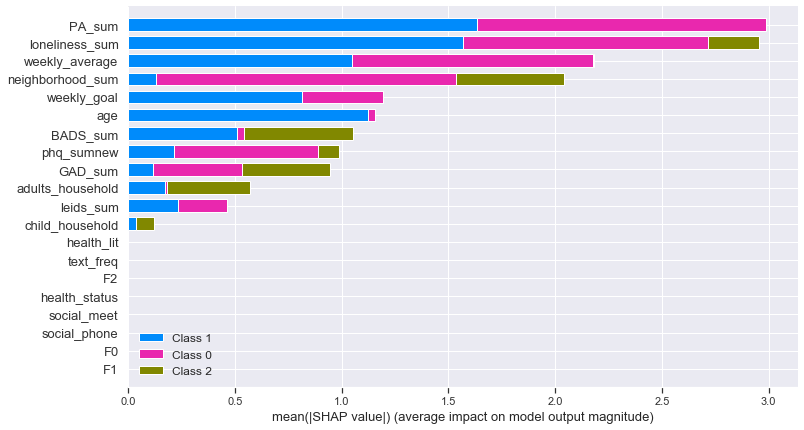

In [23]:
### SHAP summary plot ###
shap.summary_plot(shap_values_kp, cat_data, plot_type='bar', plot_size=(12,7))

In [24]:
# This gives the cluster grouping for each individual rows
cluster_dict = []
for c in clusters:
    cluster_dict.append(c)

In [25]:
# Assign back a clusters column in the dataframe to see which rows belong to which clusters
test_set["cluster_id"] = cluster_dict

C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
###############################################################################################
##### Here we converting back the scaled variables in the clusters to its original number #####
###############################################################################################

# Continuous variables
cont_variables = ["weekly_goal","weekly_average","neighborhood_sum","BADS_sum","age","GAD_sum","leids_sum",
                             "adults_household","child_household","phq_sumnew","PA_sum","loneliness_sum"] 
List = []
for i in kproto.cluster_centroids_[0]:
    lst = []
    for j in range(12):         # Times standard deviation plus mean
        lst.append(round(i[j] * df_new_weekly_bystudydays[cont_variables[j]].std() + df_new_weekly_bystudydays[cont_variables[j]].mean(),3))
    List.append(lst)

cont_variables_df = pd.DataFrame(List, columns = cont_variables)

# Categorical variables
cat_variables = ["social_rel","health_lit","text_freq","health_status","social_meet","social_phone","F0","F1","F2"
                 ,"F3","F4","M0","M1","M2","M3","arm","week_number"]
Cat = []
for i in kproto.cluster_centroids_[1]:
    lst = []
    for j in range(17): # 17 is the number of variables
        lst.append(i[j])
    Cat.append(lst)

cat_variables_df = pd.DataFrame(Cat, columns = cat_variables)

clusters = cont_variables_df.join(cat_variables_df)
print(clusters)

clusters.to_csv("clusters_weekly_studydays_arm0_final.csv")

   weekly_goal  weekly_average  neighborhood_sum  BADS_sum     age  GAD_sum  \
0    52172.510        6946.744            16.808    29.462  21.823    5.494   
1    66894.148       10101.729            13.233    31.154  19.838    3.423   
2    55995.769        9179.584             8.995    38.008  21.001   -0.004   

   leids_sum  adults_household  child_household  phq_sumnew   PA_sum  \
0     14.105             3.432            0.418       7.166   79.594   
1     12.711             2.981            0.315       4.098  210.760   
2     14.001            55.052            2.002       2.997  180.008   

   loneliness_sum                                    social_rel   health_lit  \
0           7.091  I do not attend church or religious services  Quite a bit   
1           4.594  I do not attend church or religious services  Quite a bit   
2           2.997  I do not attend church or religious services    Extremely   

             text_freq health_status          social_meet  \
0  Several t

## K-prototypes

### Weekly_average_steps for arm 1 

In [27]:
# Run kprototypes with importance at least 0.006 and above (remove edu and eth and employed)
from sklearn.preprocessing import StandardScaler

# change arm from int to object
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"arm":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"week_number":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"M0":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"M1":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"M2":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"M3":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"F0":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"F1":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"F2":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"F3":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"F4":"object"})

# Separating out the features
features = df_new_weekly_bystudydays[["weekly_goal","weekly_average","neighborhood_sum","BADS_sum","social_rel","health_lit","text_freq",
                                    "age","GAD_sum","leids_sum","week_number","adults_household","phq_sumnew","PA_sum",
                                     "health_status","loneliness_sum","social_meet","social_phone","F0","F1","F2"
                                      ,"F3","F4","M0","M1","M2","M3","arm","child_household"]]

# Categorical features (drop out those continuous variables)
cat_features = features.drop(["week_number","weekly_goal",
                             "weekly_average","neighborhood_sum","BADS_sum","age","GAD_sum","leids_sum",
                             "adults_household","child_household","phq_sumnew","PA_sum","loneliness_sum"], axis=1).reset_index()

# Continuous features
cont_features = features[["weekly_goal","weekly_average","neighborhood_sum","BADS_sum","age","GAD_sum","leids_sum",
                             "adults_household","child_household","phq_sumnew","PA_sum","loneliness_sum"]]

# Standardizing the continuous features
features_stand = StandardScaler().fit_transform(cont_features)
features_stand = pd.DataFrame(features_stand, columns = ["weekly_goal","weekly_average","neighborhood_sum","BADS_sum","age","GAD_sum"
                                                         ,"leids_sum","adults_household","child_household","phq_sumnew","PA_sum",
                                                         "loneliness_sum"]).reset_index()

# Features that don't need to be changed
features_same = features["week_number"]

# Combining back the categorical and numerical variables
df_weekly_stand_new = pd.concat([cat_features, features_same, features_stand], axis=1, sort=False)
# Drop the index column
#pd.set_option("display.max_rows", 5, "display.max_columns", None) 
df_weekly_stand_new = df_weekly_stand_new.drop(["index"],axis=1) # remove the index column
df_weekly_stand_new = df_weekly_stand_new.dropna() # drop the nan

In [28]:
# Split into training and test set

df_arm_1 = df_weekly_stand_new[df_weekly_stand_new["arm"] == 1]
train_set = df_arm_1[df_arm_1["week_number"] <= 3]
test_set = df_arm_1[df_arm_1["week_number"] > 3]

# Setting the objects to category
cat_data = test_set.copy()
for j in cat_data.select_dtypes("object"):
    cat_data[j] = cat_data[j].astype("category")

# Elbow plot with cost 
costs = []
n_clusters = []
clusters_assigned = []
F1_scores = pd.DataFrame(columns = ['Number of clusters', 'F1 score'])

for i in tqdm(range(2, 18)):
    try:        
        # Step 1: Initialize the function by specifying the number of clusters
        kproto = KPrototypes(n_clusters= i, init='Huang', verbose=2, random_state = 100)
    
        # Step 2: To build the clusters, fit.predict the data
        clusters = kproto.fit_predict(train_set, categorical=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
        
        # Step 3: Append the cost and number of clusters used to compute the cost to appropriate lists
        costs.append(kproto.cost_)
        n_clusters.append(i)
        clusters_assigned.append(clusters)
        
        # Predicted Clusters using test set
        kproto_test = KPrototypes(n_clusters= i, init='Huang', verbose=2, random_state = 100)
        clusters_test = kproto_test.fit_predict(test_set, categorical=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

        # kprototypes labels
        proto_labs = kproto_test.labels_ 
        
        clf_kp = LGBMClassifier(colsample_by_tree = 0.8)
        cv_scores_kp_test = cross_val_score(clf_kp, cat_data, proto_labs, scoring = "f1_weighted")
        print(f'CV F1 score for {i}-prototypes clusters is {np.mean(cv_scores_kp_test)}')
        
        # Create a dataframe to store the F1_scores for all the different clusters
        F1_scores = F1_scores.append(pd.DataFrame({'Number of clusters': i, 
                                                       'F1 score': np.mean(cv_scores_kp_test)},
                                                       index = [0]),
                                         ignore_index = True)
    except:
        print(f"Can't cluster with {i} clusters")

# Construct an elbow plot to find the optimal number for K
fig = go.Figure(data=go.Scatter(x=n_clusters, y=costs ))
fig.show()

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 7, ncost: 673.3735601269098
Run: 1, iteration: 2/100, moves: 1, ncost: 671.308746568435
Run: 1, iteration: 3/100, moves: 3, ncost: 666.8520310041296
Run: 1, iteration: 4/100, moves: 0, ncost: 666.8520310041296
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 0, ncost: 777.365268385499
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 10, ncost: 672.9613594132222
Run: 3, iteration: 2/100, moves: 0, ncost: 672.9613594132222
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 9, ncost: 677.9636667975897
Run: 4, iteration: 2/100, moves: 1, ncost: 676.248842896242
Run: 4, iteration: 3/100, moves: 1, ncost: 675.3315658552931
Run: 4, iteration: 4/100, moves: 0, ncost: 675.3315658552931
Init: initi

  6%|█████▏                                                                             | 1/16 [00:02<00:32,  2.14s/it]

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 18, ncost: 630.4157269071885
Run: 1, iteration: 2/100, moves: 3, ncost: 623.1335011433332
Run: 1, iteration: 3/100, moves: 0, ncost: 623.1335011433332
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 18, ncost: 648.94165817916
Run: 2, iteration: 2/100, moves: 9, ncost: 629.0001446295107
Run: 2, iteration: 3/100, moves: 2, ncost: 625.902007515223
Run: 2, iteration: 4/100, moves: 1, ncost: 624.0712201954337
Run: 2, iteration: 5/100, moves: 0, ncost: 624.0712201954337
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 9, ncost: 610.5754629472777
Run: 3, iteration: 2/100, moves: 5, ncost: 594.2682660687121
Run: 3, iteration: 3/100, moves: 0, ncost: 594.2682660687121
Init: initializing centroids
Init

 12%|██████████▍                                                                        | 2/16 [00:04<00:32,  2.30s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 14, ncost: 564.9675138434932
Run: 1, iteration: 2/100, moves: 4, ncost: 558.4174914670431
Run: 1, iteration: 3/100, moves: 1, ncost: 556.5128741140882
Run: 1, iteration: 4/100, moves: 0, ncost: 556.5128741140882
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 5, ncost: 584.5748602405126
Run: 2, iteration: 2/100, moves: 8, ncost: 545.7204098058148
Run: 2, iteration: 3/100, moves: 0, ncost: 545.7204098058148
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 10, ncost: 542.3675751436797
Run: 3, iteration: 2/100, moves: 3, ncost: 534.3426154095728
Run: 3, iteration: 3/100, moves: 0, ncost: 534.3426154095728
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, ite

 19%|███████████████▌                                                                   | 3/16 [00:07<00:32,  2.47s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 14, ncost: 532.3455540149469
Run: 1, iteration: 2/100, moves: 4, ncost: 525.9244353355186
Run: 1, iteration: 3/100, moves: 4, ncost: 519.9079297090964
Run: 1, iteration: 4/100, moves: 1, ncost: 519.4681158190226
Run: 1, iteration: 5/100, moves: 0, ncost: 519.4681158190226
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 11, ncost: 547.5932138923501
Run: 2, iteration: 2/100, moves: 7, ncost: 520.4159732761183
Run: 2, iteration: 3/100, moves: 0, ncost: 520.4159732761183
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 10, ncost: 566.816807249199
Run: 3, iteration: 2/100, moves: 1, ncost: 563.0780765424988
Run: 3, iteration: 3/100, moves: 0, ncost: 563.0780765424988
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4,

 25%|████████████████████▊                                                              | 4/16 [00:10<00:29,  2.49s/it]

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 17, ncost: 483.7679547753948
Run: 1, iteration: 2/100, moves: 2, ncost: 479.5937373168259
Run: 1, iteration: 3/100, moves: 1, ncost: 477.21287097300217
Run: 1, iteration: 4/100, moves: 1, ncost: 474.1324796879388
Run: 1, iteration: 5/100, moves: 1, ncost: 471.418860613838
Run: 1, iteration: 6/100, moves: 0, ncost: 471.418860613838
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 10, ncost: 476.91810421420774
Run: 2, iteration: 2/100, moves: 0, ncost: 476.91810421420774
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 19, ncost: 470.35427053688034
Run: 3, iteration: 2/100, moves: 1,

 31%|█████████████████████████▉                                                         | 5/16 [00:13<00:30,  2.76s/it]

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 15, ncost: 464.87672215551834
Run: 1, iteration: 2/100, moves: 1, ncost: 462.97642760267985
Run: 1, iteration: 3/100, moves: 0, ncost: 462.97642760267985
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 11, ncost: 469.8241112573634
Run: 2, iteration: 2/100, moves: 3, ncost: 467.08869685577
Run: 2, iteration: 3/100, moves: 1, ncost: 465.83941143201025
Run: 2, iteration: 4/100, moves: 0, ncost: 465.83941143201025
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 12, ncost: 462.0119572209355
Run: 3, iteration: 2/100, moves: 5, ncost: 454.53341387710464
Run: 3, iteration: 3/100, moves: 0, ncost: 454.53341387710464
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids

C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 7-prototypes clusters is 0.9637676609105181


 38%|███████████████████████████████▏                                                   | 6/16 [00:16<00:28,  2.85s/it]

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 11, ncost: 419.6155567228655
Run: 1, iteration: 2/100, moves: 7, ncost: 398.5471857514702
Run: 1, iteration: 3/100, moves: 0, ncost: 398.5471857514702
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 9, ncost: 438.10603108602857
Run: 2, iteration: 2/100, moves: 3, ncost: 429.9517482573063
Run: 2, iteration: 3/100, moves: 0, ncost: 429.9517482573063
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 12, ncost: 419.2060825355032
Run: 3, iteration: 2/100, moves: 1, ncost: 418.67319920422125
Run: 3, iteration: 3/100, moves: 0, ncost: 418.67319920422125
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: 

C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 8-prototypes clusters is 0.9107692307692308


 44%|████████████████████████████████████▎                                              | 7/16 [00:20<00:27,  3.08s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 9, ncost: 419.6865232945346
Run: 1, iteration: 2/100, moves: 0, ncost: 419.6865232945346
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 13, ncost: 450.51241731898347
Run: 2, iteration: 2/100, moves: 5, ncost: 430.4429757143836
Run: 2, iteration: 3/100, moves: 2, ncost: 425.43460756759936
Run: 2, iteration: 4/100, moves: 2, ncost: 420.59449810118286
Run: 2, iteration: 5/100, moves: 0, ncost: 420.59449810118286
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: ini

Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 12, ncost: 431.5434132823491
Run: 6, iteration: 2/100, moves: 0, ncost: 431.5434132823491
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 18, ncost: 470.4546872747544
Run: 7, iteration: 2/100, moves: 6, ncost: 432.2653339253306
Run: 7, iteration: 3/100, moves: 2, ncost: 422.2797951520651
Run: 7, iteration: 4/100, moves: 0, ncost: 422.2797951520651
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializi

C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 9-prototypes clusters is 0.7563614163614164


 50%|█████████████████████████████████████████▌                                         | 8/16 [00:24<00:26,  3.32s/it]

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 16, ncost: 415.39619008075164
Run: 1, iteration: 2/100, moves: 7, ncost: 393.41508830113014
Run: 1, iteration: 3/100, moves: 0, ncost: 393.41508830113014
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 14, ncost: 375.13349557755396
Run: 2, iteration: 2/100, moves: 2, ncost: 371.1895408991224
Run: 2, iteration: 3/100, moves: 0, ncost: 371.1895408991224
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting ite

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 18, ncost: 425.24009161737166
Run: 6, iteration: 2/100, moves: 3, ncost: 416.58795374393816
Run: 6, iteration: 3/100, moves: 0, ncost: 416.58795374393816
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 21, ncost: 397.7474755187445
Run: 7, iteration: 2/100, moves: 1, ncost: 395.7030958775064
Run: 7, iteration: 3/100, moves: 0, ncost: 395.7030958775064
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 8, iteration: 1/100, moves: 23, ncost: 421.47173193770044
Run: 8, iteration: 2/100, moves: 7, ncost: 394.3147526700892
Run: 8, iteration: 3/100, moves: 0, ncost: 394.3147526700892
Init: initializing centroids
Init

C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 10-prototypes clusters is 0.9475457875457876


 56%|██████████████████████████████████████████████▋                                    | 9/16 [00:27<00:24,  3.43s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 11, ncost: 359.9249486292763
Run: 1, iteration: 2/100, moves: 2, ncost: 355.7976383721232
Run: 1, iteration: 3/100, moves: 0, ncost: 355.7976383721232
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 16, ncost: 356.7976932559391
Run: 2, iteration: 2/100, moves: 3, ncost: 345.30511953386457
Run: 2, iteration: 3/100, moves: 2, ncost: 341.8697147017245
Run: 2, iteration: 4/100, moves: 1, ncost: 340.72262160285146
Run: 2, it

Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 11, ncost: 397.8266768808892
Run: 4, iteration: 2/100, moves: 4, ncost: 384.5008521933331
Run: 4, iteration: 3/100, moves: 2, ncost: 377.96325460554766
Run: 4, iteration: 4/100, moves: 0, ncost: 377.96325460554766
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing

C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 11-prototypes clusters is 0.8347985347985347


 62%|███████████████████████████████████████████████████▎                              | 10/16 [00:32<00:22,  3.69s/it]

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 10, ncost: 383.62400338449237
Run: 1, iteration: 2/100, moves: 6, ncost: 355.041226389307

Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Ini

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 15, ncost: 396.10000817664155
Run: 4, iteration: 2/100, moves: 2, ncost: 385.85020459569995
Run: 4, iteration: 3/100, moves: 0, ncost: 385.85020459569995
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 18, ncost: 335.2812007089345
Run: 5, iteration: 2/100, moves: 0, ncost: 335.2812007089345
Init: initializin

C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 12-prototypes clusters is 0.9314835164835165


 69%|████████████████████████████████████████████████████████▍                         | 11/16 [00:38<00:23,  4.60s/it]

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
In

Starting iterations...
Run: 5, iteration: 1/100, moves: 17, ncost: 340.2818875864829
Run: 5, iteration: 2/100, moves: 2, ncost: 331.1564140010183
Run: 5, iteration: 3/100, moves: 0, ncost: 331.1564140010183
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 17, ncost: 315.8793788048633
Run: 6, iteration: 2/100, moves: 3, ncost: 304.21215610193565
Run: 6, iteration: 3/100, moves: 1, ncost: 301.82352560657534
Run: 6, iteration: 4/100, moves: 0, ncost: 301.82352560657534
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 17, ncost: 286.7748526464843
Run: 7, iteration: 2/100, moves: 0, ncost: 286.7748526464843
Init: initializing centroids
Init:

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
In

Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Ini

C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 13-prototypes clusters is 0.9068864468864468


 75%|█████████████████████████████████████████████████████████████▌                    | 12/16 [00:46<00:22,  5.59s/it]

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 12, ncost: 299.9141099583267
Run: 1, iteration: 2/100, moves: 1, ncost: 297.6445838208615
Run: 1, iteration: 3/100, moves: 0, ncost: 297.6445838208615
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clus

 81%|██████████████████████████████████████████████████████████████████▋               | 13/16 [00:48<00:13,  4.40s/it]

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
In

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
In

 88%|███████████████████████████████████████████████████████████████████████▊          | 14/16 [00:51<00:08,  4.05s/it]

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
In

 94%|████████████████████████████████████████████████████████████████████████████▉     | 15/16 [00:52<00:03,  3.20s/it]

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
In

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:53<00:00,  3.37s/it]


In [29]:
# F1_scores for the different clusters
print(F1_scores)

   Number of clusters  F1 score
0                   2  0.969597
1                   3  0.804735
2                   4  0.808309
3                   5  0.718842
4                   6  0.897326
5                   7  0.963768
6                   8  0.910769
7                   9  0.756361
8                  10  0.947546
9                  11  0.834799
10                 12  0.931484
11                 13  0.906886


In [30]:
# Split into training and test set
df_arm_1 = df_weekly_stand_new[df_weekly_stand_new["arm"] == 1]
train_set = df_arm_1[df_arm_1["week_number"] <= 3]
test_set = df_arm_1[df_arm_1["week_number"] > 3]

# categorical columns
categorical_columns = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

kproto = KPrototypes(n_clusters= 2, init='Huang', verbose=2, random_state = 100)
clusters = kproto.fit_predict(test_set, categorical=categorical_columns)

# Predicted Clusters
clusters = kproto.fit_predict(test_set, categorical=categorical_columns)
pd.set_option("display.max_rows", None, "display.max_columns", None) 

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 12, ncost: 754.6630168388443
Run: 1, iteration: 2/100, moves: 9, ncost: 732.8612603052691
Run: 1, iteration: 3/100, moves: 0, ncost: 732.8612603052691
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 14, ncost: 758.9425993542546
Run: 2, iteration: 2/100, moves: 0, ncost: 758.9425993542546
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 12, ncost: 737.6060305728219
Run: 3, iteration: 2/100, moves: 0, ncost: 737.6060305728219
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 13, ncost: 777.9464289907899
Run: 4, iteration: 2/100, moves: 6, ncost: 764.338787858066
Run: 4, iteration: 3/100, moves: 6, ncost: 750.912928136896
Run: 4, iteration: 4/100, moves: 5, ncost: 734.5518717172864
Run: 4,

In [31]:
# Setting the objects to category
cat_data = test_set.copy()
for i in cat_data.select_dtypes("object"):
    cat_data[i] = cat_data[i].astype("category")

# kprototypes labels
proto_labs = kproto.labels_ 

In [32]:
from lightgbm import LGBMClassifier
clf_kp = LGBMClassifier(colsample_by_tree = 0.8)
cv_scores_kp = cross_val_score(clf_kp, cat_data, proto_labs, scoring = "f1_weighted")
print(f'CV F1 score for k-prototypes clusters is {np.mean(cv_scores_kp)}')

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for k-prototypes clusters is 0.9695970695970695


In [33]:
clf_kp.fit(cat_data, proto_labs)

[LightGBM] [Warning] Unknown parameter: colsample_by_tree


LGBMClassifier(colsample_by_tree=0.8)

In [34]:
explainer_kp = shap.TreeExplainer(clf_kp)
shap_values_kp = explainer_kp.shap_values(cat_data)

C:\Users\Kiat Kai\AppData\Roaming\Python\Python37\site-packages\shap\explainers\_tree.py:300: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



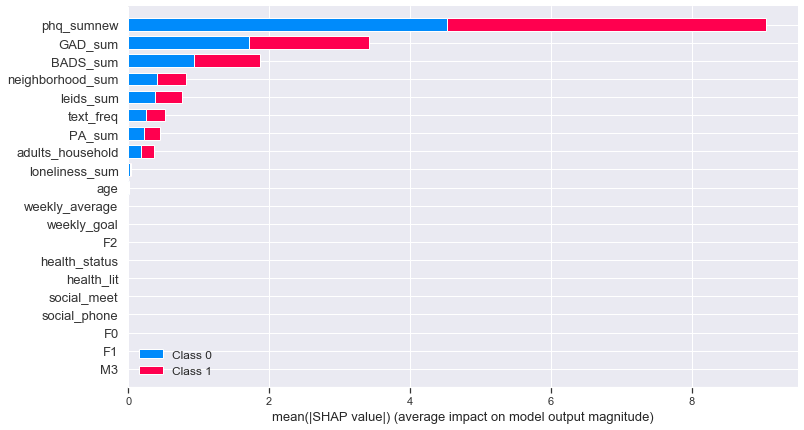

In [35]:
### SHAP summary plot ###
shap.summary_plot(shap_values_kp, cat_data, plot_type='bar', plot_size=(12,7))

In [36]:
# This gives the cluster grouping for each individual rows
cluster_dict = []
for c in clusters:
    cluster_dict.append(c)

In [37]:
# Assign back a clusters column in the dataframe to see which rows belong to which clusters
test_set["cluster_id"] = cluster_dict

C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [38]:
###############################################################################################
##### Here we converting back the scaled variables in the clusters to its original number #####
###############################################################################################

# Continuous variables
cont_variables = ["weekly_goal","weekly_average","neighborhood_sum","BADS_sum","age","GAD_sum","leids_sum",
                             "adults_household","child_household","phq_sumnew","PA_sum","loneliness_sum"] 
List = []
for i in kproto.cluster_centroids_[0]:
    lst = []
    for j in range(12):         # Times standard deviation plus mean
        lst.append(round(i[j] * df_new_weekly_bystudydays[cont_variables[j]].std() + df_new_weekly_bystudydays[cont_variables[j]].mean(),3))
    List.append(lst)

cont_variables_df = pd.DataFrame(List, columns = cont_variables)

# Categorical variables
cat_variables = ["social_rel","health_lit","text_freq","health_status","social_meet","social_phone","F0","F1","F2"
                 ,"F3","F4","M0","M1","M2","M3","arm","week_number"]
Cat = []
for i in kproto.cluster_centroids_[1]:
    lst = []
    for j in range(17): # 17 is the number of variables
        lst.append(i[j])
    Cat.append(lst)

cat_variables_df = pd.DataFrame(Cat, columns = cat_variables)

clusters = cont_variables_df.join(cat_variables_df)
print(clusters)

clusters.to_csv("clusters_weekly_studydays_arm1_final.csv")

   weekly_goal  weekly_average  neighborhood_sum  BADS_sum     age  GAD_sum  \
0    52510.436        7758.785            14.523    26.542  19.022    1.930   
1    59048.848        8473.663            11.634    33.640  18.999    9.278   

   leids_sum  adults_household  child_household  phq_sumnew   PA_sum  \
0     12.067             3.067            0.182       3.999  202.531   
1     17.732             3.272            0.364       9.641  175.231   

   loneliness_sum                                    social_rel   health_lit  \
0           4.681  I do not attend church or religious services  Quite a bit   
1           7.047  I do not attend church or religious services  Quite a bit   

             text_freq health_status          social_meet  \
0  Several times a day     Very Good  Several times a day   
1  Several times a day     Very Good     About once a day   

          social_phone F0 F1 F2 F3 F4 M0 M1 M2 M3  arm week_number  
0  About once per week  1  0  0  0  0  2  0  1  2  

### K-Mediods

In [39]:
# Rrun K-Mediods with importance at least 0.006 and above (remove edu and eth and employed)

# change arm from int to object
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"arm":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"week_number":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"M0":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"M1":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"M2":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"M3":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"F0":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"F1":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"F2":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"F3":"object"})
df_new_weekly_bystudydays = df_new_weekly_bystudydays.astype({"F4":"object"})

# Separating out the features
features = df_new_weekly_bystudydays[["weekly_goal","weekly_average","neighborhood_sum","BADS_sum","social_rel","health_lit","text_freq",
                                    "age","GAD_sum","leids_sum","week_number","adults_household","phq_sumnew","PA_sum",
                                     "health_status","loneliness_sum","social_meet","social_phone","F0","F1","F2"
                                      ,"F3","F4","M0","M1","M2","M3","arm","child_household"]]

# Categorical features (drop out those continuous variables)
cat_features = features.drop(["week_number","weekly_goal",
                             "weekly_average","neighborhood_sum","BADS_sum","age","GAD_sum","leids_sum",
                             "adults_household","child_household","phq_sumnew","PA_sum","loneliness_sum"], axis=1).reset_index()

# Continuous features
cont_features = features[["weekly_goal","weekly_average","neighborhood_sum","BADS_sum","age","GAD_sum","leids_sum",
                             "adults_household","child_household","phq_sumnew","PA_sum","loneliness_sum"]]

# Standardizing the continuous features
features_stand = StandardScaler().fit_transform(cont_features)
features_stand = pd.DataFrame(features_stand, columns = ["weekly_goal","weekly_average","neighborhood_sum","BADS_sum","age","GAD_sum"
                                                         ,"leids_sum","adults_household","child_household","phq_sumnew","PA_sum",
                                                         "loneliness_sum"]).reset_index()

# Features that don't need to be changed
features_same = features["week_number"]

# Combining back the categorical and numerical variables
df_weekly_stand_new = pd.concat([cat_features, features_same, features_stand], axis=1, sort=False)
# Drop the index column
#pd.set_option("display.max_rows", 5, "display.max_columns", None) 
df_weekly_stand_new = df_weekly_stand_new.drop(["index"],axis=1) # remove the index column
df_weekly_stand_new = df_weekly_stand_new.dropna() # drop the nan

# Combining back the categorical and numerical variables
df_weekly_kmeans = pd.concat([cat_features, features_same, features_stand], axis=1, sort=False)

df_weekly_kmeans = df_weekly_kmeans.drop(["index"],axis=1) # remove the index column
df_weekly_kmeans = df_weekly_kmeans.dropna() # drop the nan

# Split into arm 0 and arm 1
df_weekly_kmeans_arm0 = df_weekly_kmeans[df_weekly_kmeans["arm"]==0]
df_weekly_kmeans_arm1 = df_weekly_kmeans[df_weekly_kmeans["arm"]==1]

# Split into train and test set before converting "week_number" into ordinal variable
train_set_beforedummy_arm0 = df_weekly_kmeans_arm0[df_weekly_kmeans_arm0["week_number"] <= 4]
test_set_beforedummy_arm0 = df_weekly_kmeans_arm0[df_weekly_kmeans_arm0["week_number"] > 4]

train_set_beforedummy_arm1 = df_weekly_kmeans_arm1[df_weekly_kmeans_arm1["week_number"] <= 4]
test_set_beforedummy_arm1 = df_weekly_kmeans_arm1[df_weekly_kmeans_arm1["week_number"] > 4]

# Get dummies (ENCODING into dummy variables)
train_set_afterdummy_arm0 = pd.get_dummies(train_set_beforedummy_arm0)
test_set_afterdummy_arm0 = pd.get_dummies(test_set_beforedummy_arm0)

train_set_afterdummy_arm1 = pd.get_dummies(train_set_beforedummy_arm1)
test_set_afterdummy_arm1 = pd.get_dummies(test_set_beforedummy_arm1)

In [40]:
##################################################################  # Should we standardadize the data or should
#### First we need to convert dataset to the one-hot encoding ####  # we just use the standardized dataframe
##################################################################

# Setting the objects to category
test_data_arm0 = test_set_beforedummy_arm0.copy()
for j in test_data_arm0.select_dtypes("object"):
    test_data_arm0[j] = test_data_arm0[j].astype("category")

model_outputs = pd.DataFrame(columns = ['Number of clusters', 'F1 score', 'Silhouette score'])

#Elbow method to choose the optimal number of clusters
SSE = {}

for i in tqdm(range(2, 18)):
    try:
        kmediods = KMedoids(n_clusters= i, random_state = 100).fit(train_set_afterdummy_arm0)
        SSE[i] = kmediods.inertia_

        # Predicted Clusters using test set
        kmediods_arm0_test = KMedoids(n_clusters= i, random_state = 100).fit(test_set_afterdummy_arm0)

        # kmeans labels for test set
        kmediods_arm0_labels = kmediods_arm0_test.labels_  # kmeans.labels_ gives the cluster label for each observation (row) 
        
        # F1_score 
        clf_kmediods = LGBMClassifier(colsample_by_tree = 0.8)
        cv_scores_kmediods_test_arm0 = cross_val_score(clf_kmediods, test_data_arm0, kmediods_arm0_labels, scoring = "f1_weighted")
        print(f'CV F1 score for {i}-prototypes clusters is {np.mean(cv_scores_kmediods_test_arm0)}')
        
        # Silhouette score
        ss = metrics.silhouette_score(test_set_afterdummy_arm0, kmediods_arm0_labels, metric='euclidean')
        print(ss)

        # Create a dataframe to store the F1_scores for all the different clusters
        model_outputs = model_outputs.append(pd.DataFrame({'Number of clusters': i, 
                                                           'F1 score': np.mean(cv_scores_kmediods_test_arm0),
                                                            'Silhouette score': ss},
                                                               index = [0]),
                                                                 ignore_index = True)
    except:
        print(f"Can't cluster with {i} clusters")

# Construct an elbow plot to find the optimal number for K
fig = go.Figure(data=go.Scatter(x=list(SSE.keys()), y=list(SSE.values())))
fig.show()

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 2-prototypes clusters is 0.6570405767072434
Can't cluster with 2 clusters


  6%|█████▏                                                                             | 1/16 [00:00<00:09,  1.53it/s]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 3-prototypes clusters is 0.5430292772270906
Can't cluster with 3 clusters


 12%|██████████▍                                                                        | 2/16 [00:01<00:10,  1.29it/s]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 4-prototypes clusters is 0.450295408947469
Can't cluster with 4 clusters


 19%|███████████████▌                                                                   | 3/16 [00:02<00:11,  1.18it/s]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 5-prototypes clusters is 0.4457154301297087
Can't cluster with 5 clusters


 25%|████████████████████▊                                                              | 4/16 [00:03<00:11,  1.08it/s]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 6-prototypes clusters is 0.43536699293109554
Can't cluster with 6 clusters


 31%|█████████████████████████▉                                                         | 5/16 [00:05<00:11,  1.02s/it]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 7-prototypes clusters is 0.38850569183902517
Can't cluster with 7 clusters


 38%|███████████████████████████████▏                                                   | 6/16 [00:06<00:11,  1.12s/it]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 8-prototypes clusters is 0.3825991292657959
Can't cluster with 8 clusters


 44%|████████████████████████████████████▎                                              | 7/16 [00:08<00:13,  1.48s/it]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 9-prototypes clusters is 0.38141086042795447
Can't cluster with 9 clusters


 50%|█████████████████████████████████████████▌                                         | 8/16 [00:10<00:13,  1.64s/it]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 10-prototypes clusters is 0.37834905834905835
Can't cluster with 10 clusters


 56%|██████████████████████████████████████████████▋                                    | 9/16 [00:12<00:12,  1.81s/it]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 11-prototypes clusters is 0.36546367213033876
Can't cluster with 11 clusters


 62%|███████████████████████████████████████████████████▎                              | 10/16 [00:14<00:10,  1.79s/it]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 12-prototypes clusters is 0.357664804331471
Can't cluster with 12 clusters


 69%|████████████████████████████████████████████████████████▍                         | 11/16 [00:16<00:09,  1.84s/it]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 13-prototypes clusters is 0.3700715950715951
Can't cluster with 13 clusters


 75%|█████████████████████████████████████████████████████████████▌                    | 12/16 [00:18<00:07,  1.94s/it]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 14-prototypes clusters is 0.3812960701849591
Can't cluster with 14 clusters


 81%|██████████████████████████████████████████████████████████████████▋               | 13/16 [00:21<00:06,  2.03s/it]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 15-prototypes clusters is 0.3941310541310541
Can't cluster with 15 clusters


 88%|███████████████████████████████████████████████████████████████████████▊          | 14/16 [00:23<00:04,  2.09s/it]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 16-prototypes clusters is 0.334716271382938
Can't cluster with 16 clusters


 94%|████████████████████████████████████████████████████████████████████████████▉     | 15/16 [00:27<00:02,  2.68s/it]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 17-prototypes clusters is 0.3468755935422602
Can't cluster with 17 clusters


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:31<00:00,  1.99s/it]


In [41]:
# Setting the objects to category
test_data_arm1 = test_set_beforedummy_arm1.copy()
for j in test_data_arm1.select_dtypes("object"):
    test_data_arm1[j] = test_data_arm1[j].astype("category")

model_outputs = pd.DataFrame(columns = ['Number of clusters', 'F1 score', 'Silhouette score'])

#Elbow method to choose the optimal number of clusters
SSE = {}

for i in tqdm(range(2, 18)):
    try:
        kmediods = KMedoids(n_clusters= i, random_state = 100).fit(train_set_afterdummy_arm1)
        SSE[i] = kmediods.inertia_

        # Predicted Clusters using test set
        kmediods_arm1_test = KMedoids(n_clusters= i, random_state = 100).fit(test_set_afterdummy_arm1)

        # kmeans labels for test set
        kmediods_arm1_labels = kmediods_arm1_test.labels_  
        
        # F1_score 
        clf_kmediods = LGBMClassifier(colsample_by_tree = 0.8)
        cv_scores_kmediods_test_arm1 = cross_val_score(clf_kmediods, test_data_arm1, kmediods_arm1_labels, scoring = "f1_weighted")
        print(f'CV F1 score for {i}-prototypes clusters is {np.mean(cv_scores_kmediods_test_arm1)}')
        
        # Silhouette score
        ss = metrics.silhouette_score(test_set_afterdummy_arm1, kmediods_arm1_labels, metric='euclidean')
        print(ss)

        # Create a dataframe to store the F1_scores for all the different clusters
        model_outputs = model_outputs.append(pd.DataFrame({'Number of clusters': i, 
                                                           'F1 score': np.mean(cv_scores_kmediods_test_arm1),
                                                            'Silhouette score': ss},
                                                               index = [0]),
                                                                 ignore_index = True)
    except:
        print(f"Can't cluster with {i} clusters")

# Construct an elbow plot to find the optimal number for K
fig = go.Figure(data=go.Scatter(x=list(SSE.keys()), y=list(SSE.values())))
fig.show()

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 2-prototypes clusters is 0.37142857142857144
Can't cluster with 2 clusters


  6%|█████▏                                                                             | 1/16 [00:00<00:13,  1.15it/s]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 3-prototypes clusters is 0.21948717948717947
Can't cluster with 3 clusters


 12%|██████████▍                                                                        | 2/16 [00:01<00:12,  1.11it/s]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 4-prototypes clusters is 0.1734065934065934
Can't cluster with 4 clusters


 19%|███████████████▌                                                                   | 3/16 [00:02<00:10,  1.21it/s]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 5-prototypes clusters is 0.0895104895104895
Can't cluster with 5 clusters


 25%|████████████████████▊                                                              | 4/16 [00:03<00:09,  1.22it/s]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 6-prototypes clusters is 0.0895104895104895
Can't cluster with 6 clusters


 31%|█████████████████████████▉                                                         | 5/16 [00:04<00:08,  1.26it/s]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 7-prototypes clusters is 0.04000000000000001
Can't cluster with 7 clusters


 38%|███████████████████████████████▏                                                   | 6/16 [00:05<00:08,  1.17it/s]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 8-prototypes clusters is 0.020606060606060607
Can't cluster with 8 clusters


 44%|████████████████████████████████████▎                                              | 7/16 [00:05<00:07,  1.16it/s]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 9-prototypes clusters is 0.07515151515151515
Can't cluster with 9 clusters


 50%|█████████████████████████████████████████▌                                         | 8/16 [00:06<00:07,  1.10it/s]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 10-prototypes clusters is 0.04000000000000001
Can't cluster with 10 clusters


 56%|██████████████████████████████████████████████▋                                    | 9/16 [00:07<00:06,  1.17it/s]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 11-prototypes clusters is 0.020606060606060607
Can't cluster with 11 clusters


 62%|███████████████████████████████████████████████████▎                              | 10/16 [00:08<00:05,  1.19it/s]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 12-prototypes clusters is 0.020606060606060607
Can't cluster with 12 clusters


 69%|████████████████████████████████████████████████████████▍                         | 11/16 [00:09<00:04,  1.22it/s]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 13-prototypes clusters is 0.04404040404040403
Can't cluster with 13 clusters


 75%|█████████████████████████████████████████████████████████████▌                    | 12/16 [00:10<00:03,  1.23it/s]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 14-prototypes clusters is 0.04404040404040403
Can't cluster with 14 clusters


 81%|██████████████████████████████████████████████████████████████████▋               | 13/16 [00:10<00:02,  1.23it/s]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 15-prototypes clusters is 0.01616161616161616
Can't cluster with 15 clusters


 88%|███████████████████████████████████████████████████████████████████████▊          | 14/16 [00:11<00:01,  1.24it/s]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 16-prototypes clusters is 0.020606060606060607
Can't cluster with 16 clusters


 94%|████████████████████████████████████████████████████████████████████████████▉     | 15/16 [00:12<00:00,  1.23it/s]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 17-prototypes clusters is 0.016969696969696968
Can't cluster with 17 clusters


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


In [42]:
# Setting the objects to category
test_data_arm0 = test_set_beforedummy_arm0.copy()
for j in test_data_arm0.select_dtypes("object"):
    test_data_arm0[j] = test_data_arm0[j].astype("category")

model_outputs = pd.DataFrame(columns = ['Number of clusters', 'F1 score', 'Silhouette score'])

#Elbow method to choose the optimal number of clusters
SSE = {}

for i in tqdm(range(2, 18)):
    try:
        kmeans = KMeans(n_clusters= i, random_state = 100).fit(train_set_afterdummy_arm0)
        SSE[i] = kmeans.inertia_

        # Predicted Clusters using test set
        kmeans_arm0_test = KMeans(n_clusters= i, random_state = 100).fit(test_set_afterdummy_arm0)

        # kmeans labels for test set
        kmeans_arm0_labels = kmeans_arm0_test.labels_  
        
        # F1_score 
        clf_kmeans = LGBMClassifier(colsample_by_tree = 0.8)
        cv_scores_kmeans_test_arm0 = cross_val_score(clf_kmeans, test_data_arm0, kmeans_arm0_labels, scoring = "f1_weighted")
        print(f'CV F1 score for {i}-prototypes clusters is {np.mean(cv_scores_kmeans_test_arm0)}')
        
        # Silhouette score
        ss = metrics.silhouette_score(test_set_afterdummy_arm0, kmeans_arm0_labels, metric='euclidean')

        # Create a dataframe to store the F1_scores for all the different clusters
        model_outputs = model_outputs.append(pd.DataFrame({'Number of clusters': i, 
                                                           'F1 score': np.mean(cv_scores_kmeans_test_arm0),
                                                            'Silhouette score': ss},
                                                               index = [0]),
                                                                 ignore_index = True)
    except:
        print(f"Can't cluster with {i} clusters")

# Construct an elbow plot to find the optimal number for K
fig = go.Figure(data=go.Scatter(x=list(SSE.keys()), y=list(SSE.values())))
fig.show()

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 2-prototypes clusters is 0.8929487179487179
Can't cluster with 2 clusters


  6%|█████▏                                                                             | 1/16 [00:00<00:11,  1.25it/s]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 3-prototypes clusters is 0.9044430276137593
Can't cluster with 3 clusters


 12%|██████████▍                                                                        | 2/16 [00:01<00:12,  1.12it/s]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 4-prototypes clusters is 0.8740518161080597
Can't cluster with 4 clusters


 19%|███████████████▌                                                                   | 3/16 [00:03<00:12,  1.03it/s]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 5-prototypes clusters is 0.8095382601574552
Can't cluster with 5 clusters


 25%|████████████████████▊                                                              | 4/16 [00:04<00:12,  1.05s/it]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 6-prototypes clusters is 0.8544448761115427
Can't cluster with 6 clusters


 31%|█████████████████████████▉                                                         | 5/16 [00:05<00:12,  1.17s/it]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 7-prototypes clusters is 0.891382620228774
Can't cluster with 7 clusters


 38%|███████████████████████████████▏                                                   | 6/16 [00:07<00:13,  1.31s/it]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 8-prototypes clusters is 0.8405022791297301
Can't cluster with 8 clusters


 44%|████████████████████████████████████▎                                              | 7/16 [00:09<00:13,  1.51s/it]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 9-prototypes clusters is 0.7820765061149676
Can't cluster with 9 clusters


 50%|█████████████████████████████████████████▌                                         | 8/16 [00:11<00:13,  1.67s/it]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 10-prototypes clusters is 0.8320366875922429
Can't cluster with 10 clusters


 56%|██████████████████████████████████████████████▋                                    | 9/16 [00:13<00:12,  1.83s/it]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 11-prototypes clusters is 0.8076305587416698
Can't cluster with 11 clusters


 62%|███████████████████████████████████████████████████▎                              | 10/16 [00:16<00:12,  2.04s/it]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 12-prototypes clusters is 0.7887597998709109
Can't cluster with 12 clusters


 69%|████████████████████████████████████████████████████████▍                         | 11/16 [00:18<00:10,  2.13s/it]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 13-prototypes clusters is 0.7582971555193776
Can't cluster with 13 clusters


 75%|█████████████████████████████████████████████████████████████▌                    | 12/16 [00:21<00:09,  2.26s/it]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 14-prototypes clusters is 0.7455348355348356
Can't cluster with 14 clusters


 81%|██████████████████████████████████████████████████████████████████▋               | 13/16 [00:24<00:07,  2.62s/it]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 15-prototypes clusters is 0.6492585809252477
Can't cluster with 15 clusters


 88%|███████████████████████████████████████████████████████████████████████▊          | 14/16 [00:28<00:05,  2.90s/it]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 16-prototypes clusters is 0.6251064984398318
Can't cluster with 16 clusters


 94%|████████████████████████████████████████████████████████████████████████████▉     | 15/16 [00:30<00:02,  2.78s/it]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 17-prototypes clusters is 0.6889479039479041
Can't cluster with 17 clusters


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:33<00:00,  2.09s/it]


In [43]:
# Setting the objects to category
test_data_arm1 = test_set_beforedummy_arm1.copy()
for j in test_data_arm1.select_dtypes("object"):
    test_data_arm1[j] = test_data_arm1[j].astype("category")

model_outputs = pd.DataFrame(columns = ['Number of clusters', 'F1 score', 'Silhouette score'])

#Elbow method to choose the optimal number of clusters
SSE = {}

for i in tqdm(range(2, 18)):
    try:
        kmeans = KMeans(n_clusters= i, random_state = 100).fit(train_set_afterdummy_arm1)
        SSE[i] = kmeans.inertia_

        # Predicted Clusters using test set
        kmeans_arm1_test = KMeans(n_clusters= i, random_state = 100).fit(test_set_afterdummy_arm1)

        # kmeans labels for test set
        kmeans_arm1_labels = kmeans_arm1_test.labels_  
        
        # F1 score
        clf_kmeans = LGBMClassifier(colsample_by_tree = 0.8)
        cv_scores_kmeans_test_arm1 = cross_val_score(clf_kmeans, test_data_arm1, kmeans_arm1_labels, scoring = "f1_weighted")
        print(f'CV F1 score for {i}-prototypes clusters is {np.mean(cv_scores_kmeans_test_arm1)}')

        # Silhouette score
        ss = metrics.silhouette_score(test_set_afterdummy_arm1, kmeans_arm1_labels, metric='euclidean')
        print(ss)

        # Create a dataframe to store the F1_scores for all the different clusters
        model_outputs = model_outputs.append(pd.DataFrame({'Number of clusters': i, 
                                                           'F1 score': np.mean(cv_scores_kmeans_test_arm1),
                                                            'Silhouette score': ss},
                                                               index = [0]),
                                                                 ignore_index = True)
    except:
        print(f"Can't cluster with {i} clusters")

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 2-prototypes clusters is 0.418095238095238
Can't cluster with 2 clusters


  6%|█████▏                                                                             | 1/16 [00:00<00:11,  1.30it/s]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 3-prototypes clusters is 0.2974358974358974
Can't cluster with 3 clusters


 12%|██████████▍                                                                        | 2/16 [00:01<00:12,  1.14it/s]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 4-prototypes clusters is 0.2127960927960928
Can't cluster with 4 clusters


 19%|███████████████▌                                                                   | 3/16 [00:02<00:11,  1.10it/s]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 5-prototypes clusters is 0.10386946386946386
Can't cluster with 5 clusters


 25%|████████████████████▊                                                              | 4/16 [00:04<00:11,  1.03it/s]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 6-prototypes clusters is 0.12104118104118103
Can't cluster with 6 clusters


 31%|█████████████████████████▉                                                         | 5/16 [00:04<00:10,  1.07it/s]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 7-prototypes clusters is 0.0895104895104895
Can't cluster with 7 clusters


 38%|███████████████████████████████▏                                                   | 6/16 [00:05<00:08,  1.13it/s]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 8-prototypes clusters is 0.020606060606060607
Can't cluster with 8 clusters


 44%|████████████████████████████████████▎                                              | 7/16 [00:06<00:08,  1.10it/s]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 9-prototypes clusters is 0.06343434343434343
Can't cluster with 9 clusters


 50%|█████████████████████████████████████████▌                                         | 8/16 [00:07<00:07,  1.14it/s]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 10-prototypes clusters is 0.06343434343434343
Can't cluster with 10 clusters


 56%|██████████████████████████████████████████████▋                                    | 9/16 [00:08<00:06,  1.11it/s]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 11-prototypes clusters is 0.06343434343434343
Can't cluster with 11 clusters


 62%|███████████████████████████████████████████████████▎                              | 10/16 [00:09<00:05,  1.09it/s]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 12-prototypes clusters is 0.06343434343434343
Can't cluster with 12 clusters


 69%|████████████████████████████████████████████████████████▍                         | 11/16 [00:10<00:05,  1.02s/it]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 13-prototypes clusters is 0.04000000000000001
Can't cluster with 13 clusters


 75%|█████████████████████████████████████████████████████████████▌                    | 12/16 [00:11<00:04,  1.02s/it]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 14-prototypes clusters is 0.04000000000000001
Can't cluster with 14 clusters


 81%|██████████████████████████████████████████████████████████████████▋               | 13/16 [00:12<00:02,  1.01it/s]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 15-prototypes clusters is 0.020606060606060607
Can't cluster with 15 clusters


 88%|███████████████████████████████████████████████████████████████████████▊          | 14/16 [00:13<00:02,  1.02s/it]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 16-prototypes clusters is 0.012525252525252523
Can't cluster with 16 clusters


 94%|████████████████████████████████████████████████████████████████████████████▉     | 15/16 [00:14<00:01,  1.11s/it]C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=5.



[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 17-prototypes clusters is 0.01616161616161616
Can't cluster with 17 clusters


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]
